In [1]:
from os.path import join, exists
from os import makedirs, listdir
import pandas as pd
import random
import numpy as np
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn.utils import clip_grad_norm_
import torch
from torch import nn, optim
from model.dataloader import DailyTimeSeriesFromPandas
from model.networks import *

seed=1234

# For reproductibility
np.random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)

from sys import path
path.append('/home/clement/Documents/phd/JuNNo/lib/')
from junno.j_utils import log, Process
log

<IPython.core.display.Javascript object>

In [2]:
INPUT = "../data/"
input_data = pd.read_pickle(join(INPUT, "input"))
#cs_s1 and cs_s2 indicates day and night, threshold at 5 MegaWatt q3/4 in s2; wf 

In [3]:
# input_data = input_data.loc[input_data.cspower_s2 > 5] # Keep only day

input_data = input_data.between_time('6:00', '20:00')
input_data.index = pd.DatetimeIndex([i.replace(tzinfo=None) for i in input_data.index]) # Remove timezone from the timeStamp
input_data = input_data.dropna(axis="columns", how="any") # Remove columns that contain NaN

In [4]:
output_data = pd.read_pickle(join(INPUT, "output"))
output_data = output_data.loc[input_data.index, :] # Get corresponding groundtruth
if len(output_data)!= len(input_data):
    raise ValueError("Mismatch between input length (%i) and output length (%i)" 
                     %(len(input_data), len(output_data)))
# output_data = output_data.drop(columns='s2')

In [5]:
# Split between train, test and validation (60, 30, 10)
train_size = 0.6
test_size = 0.3
validation_size = max(1-train_size-test_size, 0)

list_days = output_data.index.map(lambda t: t.date()).unique() # Get list of unique days
nb_days = len(list_days)
indexes = np.arange(nb_days)
np.random.shuffle(indexes)

train_days =  list_days[indexes[:int(train_size*nb_days)]]
test_days = list_days[indexes[int(train_size*nb_days):int((test_size+train_size)*nb_days)]]
validation_days = list_days[indexes[int((train_size+test_size)*nb_days):]]

print("The training dataset has %i days, the validation dataset has %i day and the test set has %i days"
      %(len(train_days), len(validation_days), len(test_days)))

x_train = pd.concat([input_data.loc[input_data.index.date == _] for _ in train_days])
y_train = output_data.loc[x_train.index, :]
print("Train set created")

x_validation = pd.concat([input_data.loc[input_data.index.date == _] for _ in validation_days])
y_validation = output_data.loc[x_validation.index, :]
print("Validation set created")

x_test = pd.concat([input_data.loc[input_data.index.date == _] for _ in test_days])
y_test = output_data.loc[x_test.index, :]
print("Test set created")

The training dataset has 438 days, the validation dataset has 74 day and the test set has 219 days
Train set created
Validation set created
Test set created


In [6]:
train_set = DailyTimeSeriesFromPandas(x_train, y_train)
validation_set = DailyTimeSeriesFromPandas(x_validation, y_validation)
test_set = DailyTimeSeriesFromPandas(x_test, y_test)

In [7]:
# Define model
input_dimensions = len(input_data.columns)
hidden_size = 128
max_length = 27
model_name = 'lstm'
num_layers = 2
use_gpu=True
initial_lr = 1e-3
lstm = True
only_eval = False
nb_epoch = 200
batch_size = 64
bidirectional = True
cell_type = 'gru'
learning_rate_decay_fr = 25    

class CustomLSTMModel(nn.Module):
    def __init__(self, input_dimensions, 
                 hidden_size, 
                 num_layers, 
                 batch_first, 
                 out_lstm_size=2, 
                 use_conv=False,
                 bidirectional=True,
                cell_type='lstm',
                dropout=0.5):
        
        super(CustomLSTMModel, self).__init__()
        
        self.use_conv = use_conv
        
        if cell_type=='lstm':
            self.inner_model = nn.LSTM(input_dimensions, hidden_size, 
                                       dropout=dropout, num_layers=num_layers, 
                                       batch_first=batch_first, 
                                       bidirectional=bidirectional)
        elif cell_type=='gru':
            self.inner_model = nn.GRU(input_dimensions, hidden_size, 
                                       dropout=dropout, num_layers=num_layers, 
                                       batch_first=batch_first, 
                                       bidirectional=bidirectional)            
        elif cell_type=='rnn':
            self.inner_model = nn.RNN(input_dimensions, hidden_size, 
                                       num_layers=num_layers, 
                                       batch_first=batch_first, dropout=dropout, 
                                      bidirectional=bidirectional)
        if use_conv:
            self.output_model = nn.Sequential(*[nn.Conv1d(hidden_size*2, hidden_size, kernel_size=3, padding=1),
                                              nn.ReLU(True),
                                              nn.Conv1d(hidden_size, 1, kernel_size=3, padding=1),
                                              nn.ReLU(True)])
        else:
            self.output_model = nn.RNN(hidden_size*2, out_lstm_size, 
                                       num_layers=1, 
                                       batch_first=batch_first,
                                       nonlinearity='relu')

    def forward(self, x):
        if not self.use_conv:
            out, _ = self.output_model(self.inner_model(x)[0])
        else:
            lstm_out = self.inner_model(x)[0]
            lstm_out = lstm_out.transpose(1,2)
            out = self.output_model(lstm_out)
            out = out.transpose(1,2)
        return out
    
class CustomFCModel(nn.Module):
    def __init__(self, input_dimensions, hidden_size, num_layers=3):
        super(CustomFCModel, self).__init__()
        
        
        model = [nn.Conv1d(input_dimensions, hidden_size, kernel_size=1, padding=0), nn.ReLU(True)]
        for i in range(num_layers-1):
            model.append(nn.Conv1d(hidden_size//(2**i), hidden_size//(2**(i+1)), kernel_size=1))
            model.append(nn.ReLU(True))
            
        model += [nn.Conv1d(hidden_size//(2**(num_layers-1)), 2, kernel_size=1), nn.ReLU(True)]
        self.model = nn.Sequential(*model)
                                              
    def forward(self, x):
        x = x.transpose(1,2)
        out = self.model(x)
        return out.transpose(1,2)
        


In [8]:
def adjust_learning_rate(optimizer, epoch):
        """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
        lr = initial_lr * (0.5 ** (epoch // learning_rate_decay_fr))
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr  
def train(model, initial_lr, train_set, validation_set, nb_epoch, experience):
    
    output_dir = "checkpoints/"+experience+"/"
    if not exists(output_dir):
        makedirs(output_dir)
        
    criterion = nn.MSELoss()
    model.cuda()
    params = model.parameters()
    optimizer = optim.Adam(params=params, lr=initial_lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-4)
    validation_losses = []
    train_losses = []
    best_model_path = ""
    with Process(experience, nb_epoch) as p:
        p.start()
        for iter_epoch in range(nb_epoch):
            train_loader = DataLoader(dataset=train_set,
                                        batch_size=batch_size, 
                                      shuffle=True, pin_memory=True)
            p.update(1)
            for i, train_batch in enumerate(train_loader):
                train_data, train_label = train_batch
                if use_gpu:
                    train_data = train_data.cuda()
                    train_label = train_label.cuda()

                model.train(True)
                optimizer.zero_grad()
                out = model(train_data)
                train_loss = criterion(out[:,:,0], train_label[:,:,0])+criterion(out[:,:,1], train_label[:,:,1])
                train_loss.backward()
                clip_grad_norm_(parameters=params, max_norm=0.25)
                optimizer.step()


                if iter_epoch % learning_rate_decay_fr ==0:
                    adjust_learning_rate(optimizer, iter_epoch)



                if i % 5 == 0:
                    valid_loader = DataLoader(dataset=validation_set,
                                        batch_size=batch_size, shuffle=True, pin_memory=True)
                    valid_loss = []
                    with torch.no_grad():
                        for valid_batch in valid_loader:
                            valid_data, valid_label = valid_batch
                            if use_gpu:
                                valid_data = valid_data.cuda()
                                valid_label = valid_label.cuda()

                            model.train(False)
                            pred_valid = model(valid_data)
                            loss = criterion(pred_valid[:,:,0], valid_label[:,:,0]) + criterion(pred_valid[:,:,1], valid_label[:,:,1])
                            valid_loss.append(loss.cpu().numpy())
                    mean_loss = np.mean(valid_loss)
                    log.info("Epoch %i/%i, iteration %i, validation loss %.5f, training loss %.5f" 
                          %(iter_epoch, nb_epoch, i,  mean_loss, train_loss))

                    if iter_epoch and i and mean_loss < np.min(validation_losses):

                        best_model_path = join(output_dir, "e_%i_i_%i_l_%.5f.torch"%(iter_epoch, i, mean_loss))
                        torch.save(model.state_dict(), best_model_path)

                    train_losses.append(float(train_loss))
                    validation_losses.append(mean_loss)
        p.succeed()
                
    return train_losses, validation_losses, best_model_path

In [9]:
# results = {}

# exp = "bilstm"
# model = CustomLSTMModel(input_dimensions, hidden_size, num_layers, 
#                         batch_first=True, out_lstm_size=2, 
#                         use_conv=False,
#                         bidirectional=True,
#                        cell_type="lstm")
# t_l, v_l, best_model_path = train(model, initial_lr, train_set, validation_set, nb_epoch, exp)
# results[exp] = dict(train=t_l, validation=v_l, best_model_path=best_model_path)

# exp = "bigru"
# model = CustomLSTMModel(input_dimensions, hidden_size, num_layers, 
#                         batch_first=True, out_lstm_size=2, 
#                         use_conv=False,
#                         bidirectional=True,
#                        cell_type="gru")
# t_l, v_l, best_model_path = train(model, initial_lr, train_set, validation_set, nb_epoch, exp)
# results[exp] = dict(train=t_l, validation=v_l, best_model_path=best_model_path)

# exp = "birnn"
# model = CustomLSTMModel(input_dimensions, hidden_size, num_layers, 
#                         batch_first=True, out_lstm_size=2, 
#                         use_conv=False,
#                         bidirectional=True,
#                        cell_type="rnn")
# t_l, v_l, best_model_path = train(model, initial_lr, train_set, validation_set, nb_epoch, exp)
# results[exp] = dict(train=t_l, validation=v_l, best_model_path=best_model_path)

# exp = "fullyConvolutional"
# model = CustomFCModel(input_dimensions, hidden_size=256, num_layers=3)
# t_l, v_l, best_model_path = train(model, initial_lr, train_set, validation_set, nb_epoch, exp)
# results[exp] = dict(train=t_l, validation=v_l, best_model_path=best_model_path)



In [10]:
def get_best(folder):
    list_files = listdir(folder)
    losses = [float(_.split('l_')[1].replace('.torch', '')) for _ in list_files]
    argmin = np.argmin(losses)
    return join(folder, list_files[argmin])

results = {}
exp = "fullyConvolutional"    
path = join("checkpoints", exp)
path = get_best(path)
results[exp] = dict(best_model_path=path)

exp = "bilstm"    
path = join("checkpoints", exp)
path = get_best(path)
results[exp] = dict(best_model_path=path)

exp = "bigru"    
path = join("checkpoints", exp)
path = get_best(path)
results[exp] = dict(best_model_path=path)

exp = "birnn"    
path = join("checkpoints", exp)
path = get_best(path)
results[exp] = dict(best_model_path=path)

In [11]:
exp = "fullyConvolutional"
model_fullyConvolutional = CustomFCModel(input_dimensions, hidden_size=256, num_layers=3)   
model_fullyConvolutional.load_state_dict(torch.load(results[exp]['best_model_path']))

exp = "bilstm"
model_lstm = CustomLSTMModel(input_dimensions, hidden_size, num_layers, 
                        batch_first=True, out_lstm_size=2, 
                        use_conv=False,
                        bidirectional=True,
                       cell_type="lstm")
model_lstm.load_state_dict(torch.load(results[exp]['best_model_path']))

exp = "bigru"
model_gru = CustomLSTMModel(input_dimensions, hidden_size, num_layers, 
                        batch_first=True, out_lstm_size=2, 
                        use_conv=False,
                        bidirectional=True,
                       cell_type="gru")
model_gru.load_state_dict(torch.load(results[exp]['best_model_path']))

exp = "birnn"
model_rnn = CustomLSTMModel(input_dimensions, hidden_size, num_layers, 
                        batch_first=True, out_lstm_size=2, 
                        use_conv=False,
                        bidirectional=True,
                       cell_type="rnn")
model_rnn.load_state_dict(torch.load(results[exp]['best_model_path']))


models = [(model_fullyConvolutional, 'fc'), (model_lstm, 'lstm'), (model_gru, 'gru'), (model_rnn, 'rnn')]


/home/clement/miniconda3/envs/py37/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


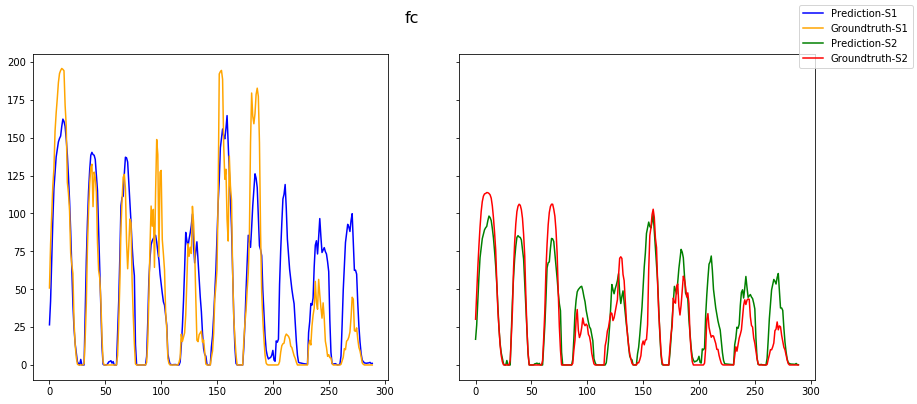

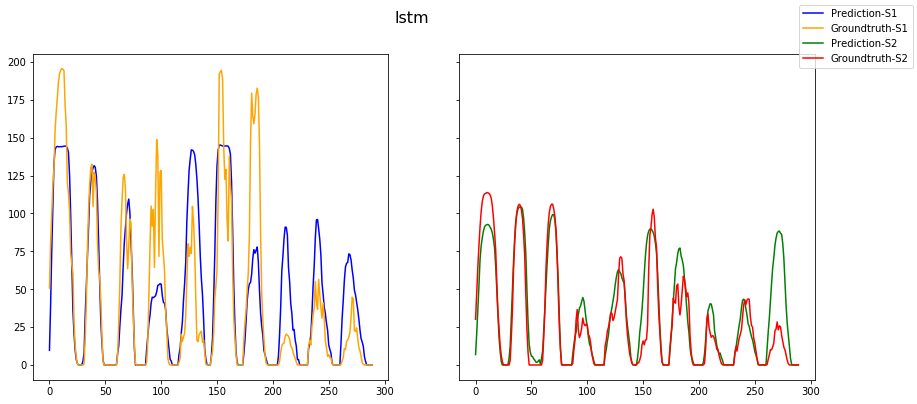

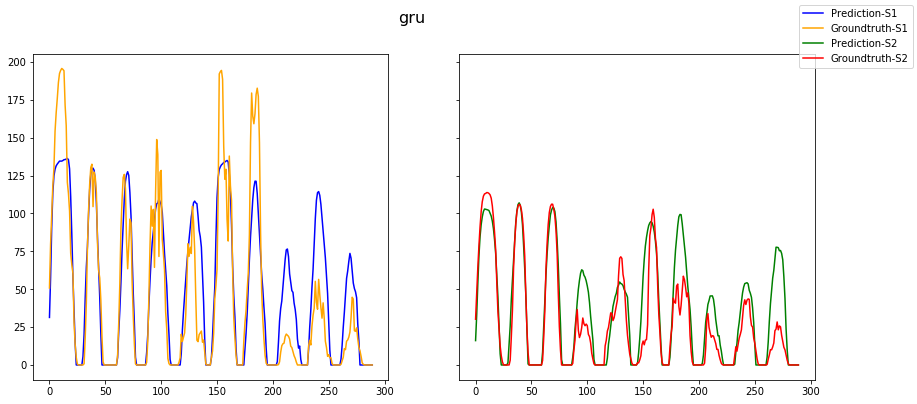

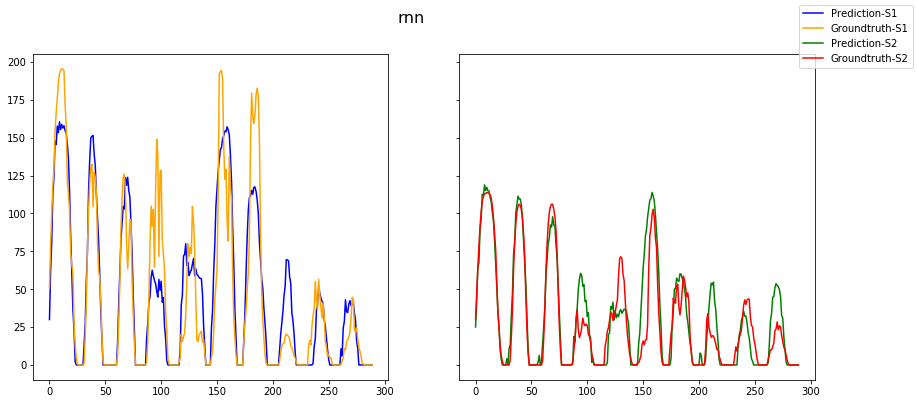

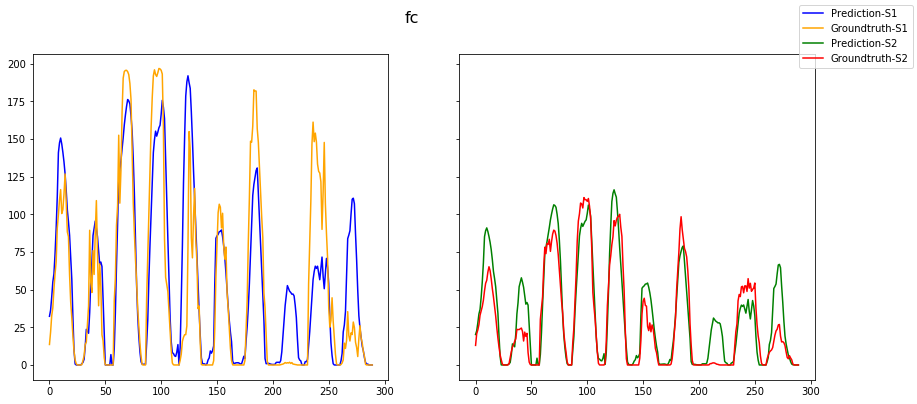

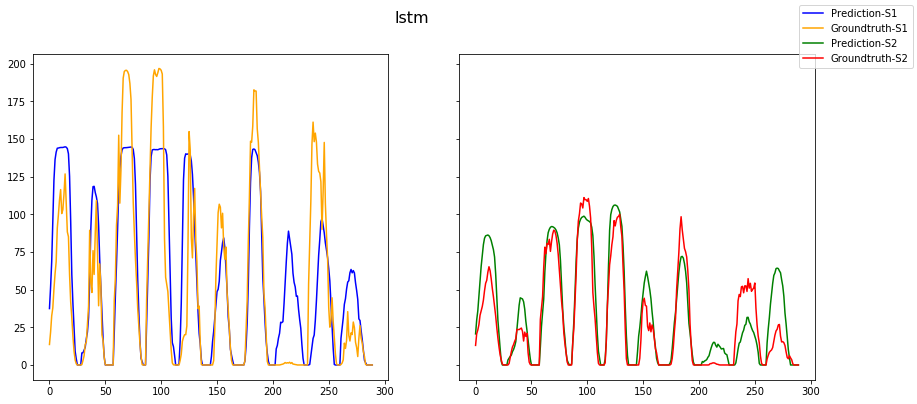

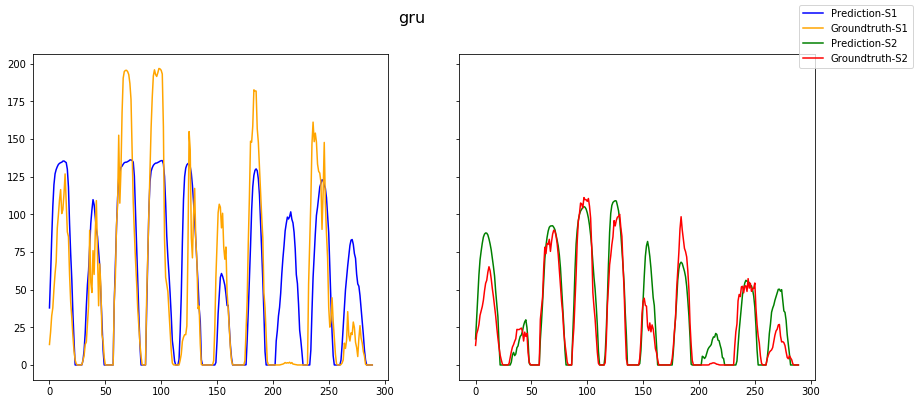

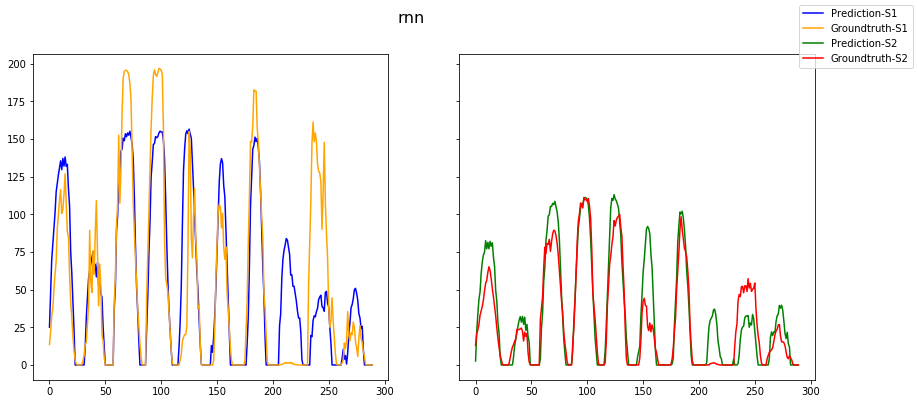

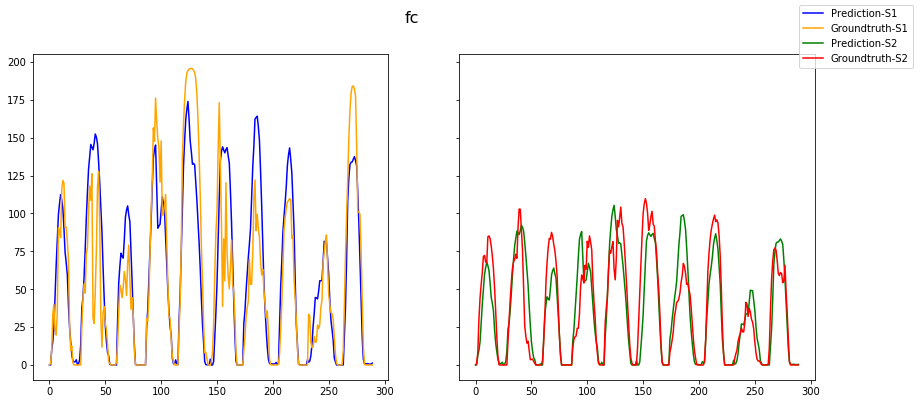

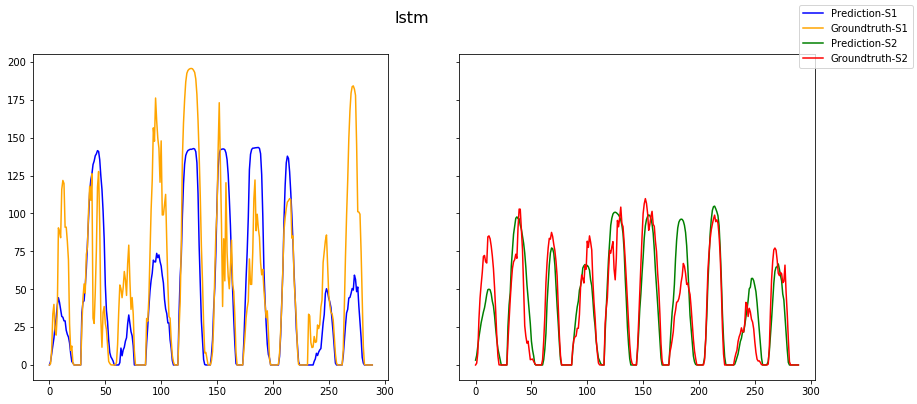

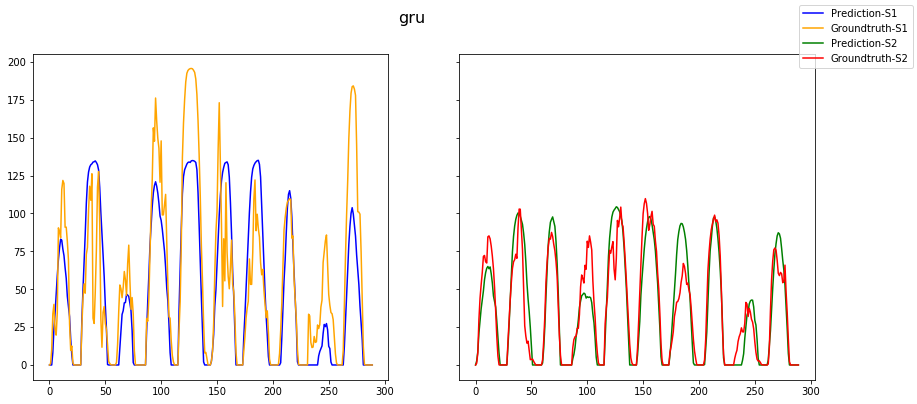

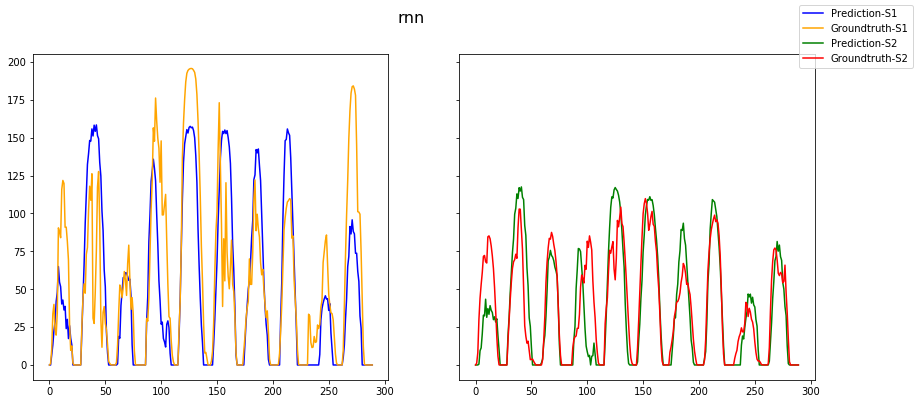

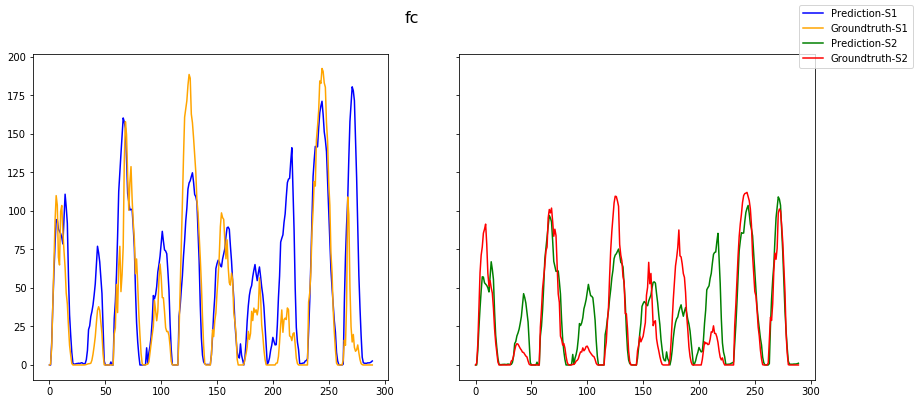

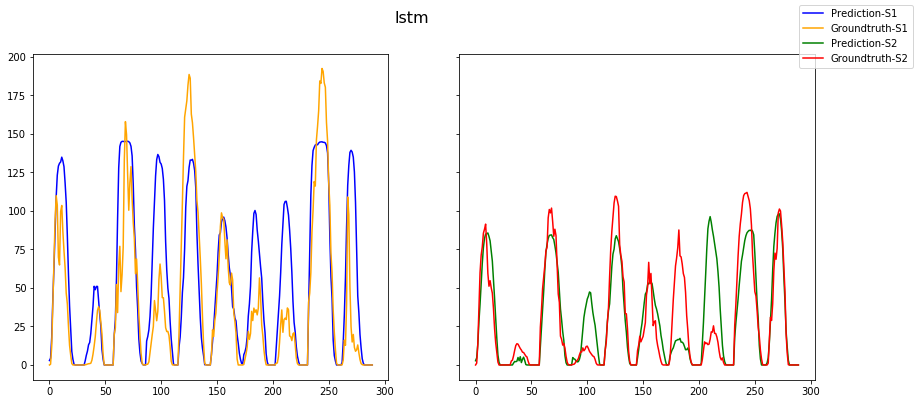

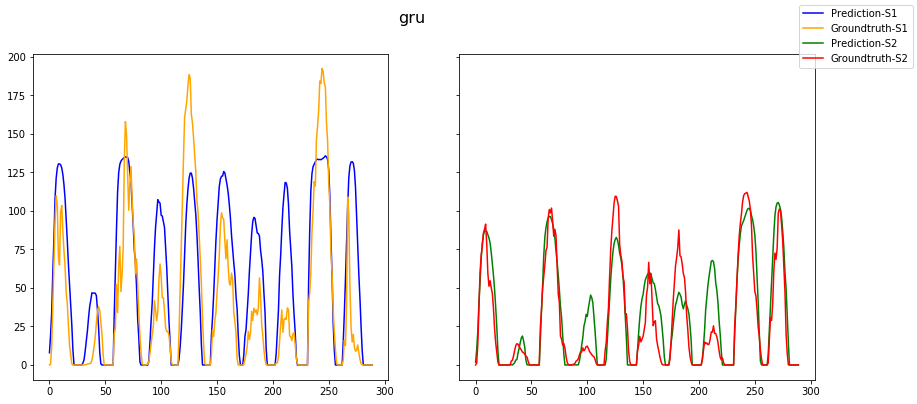

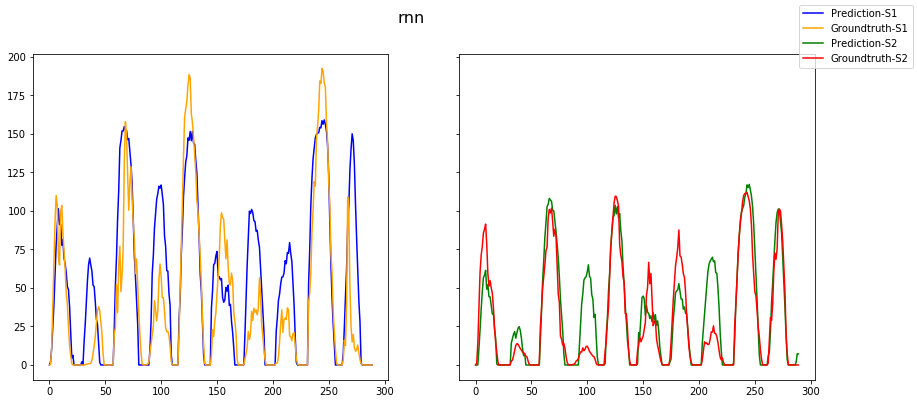

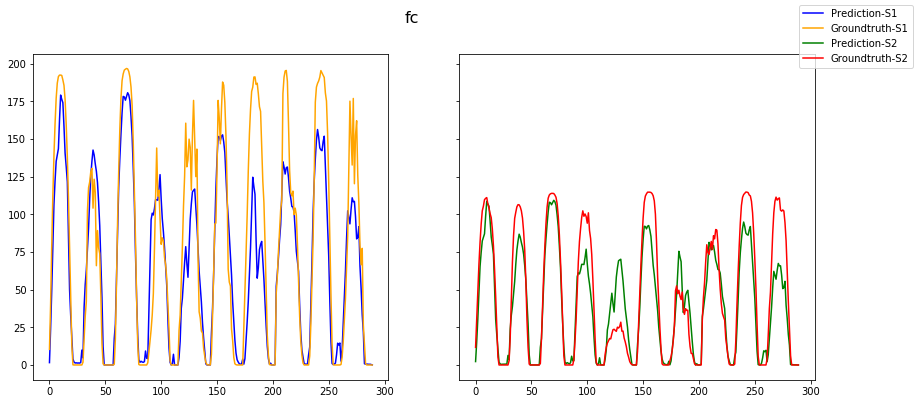

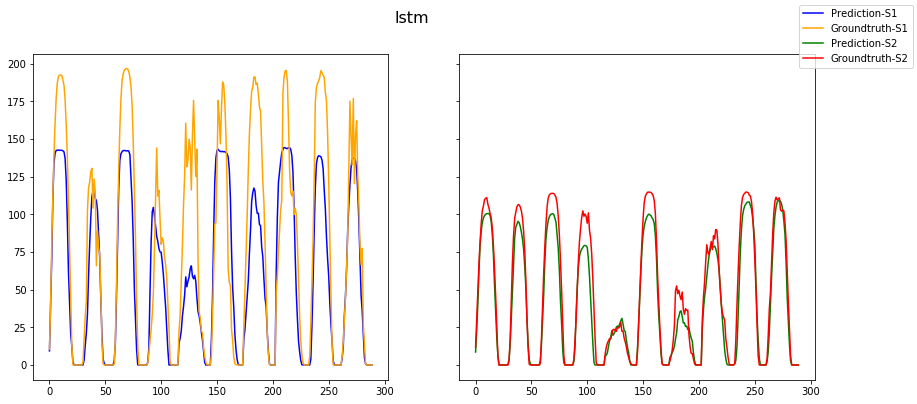

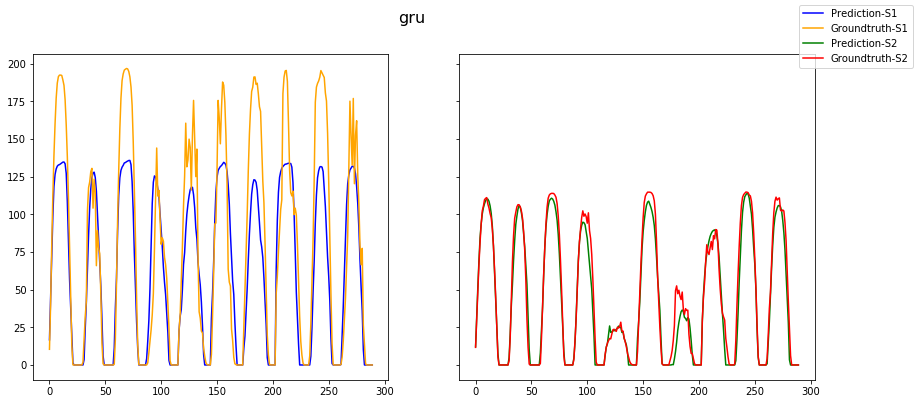

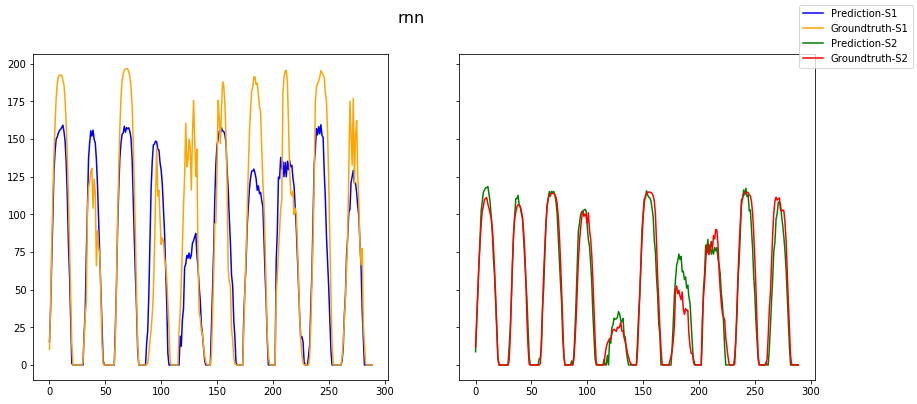

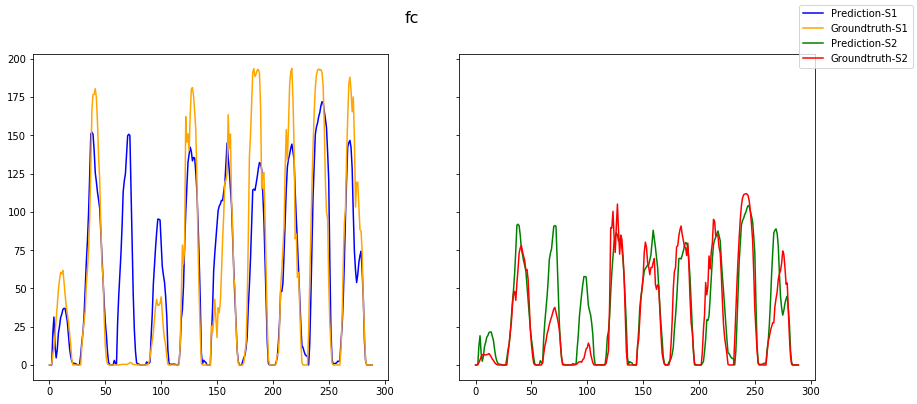

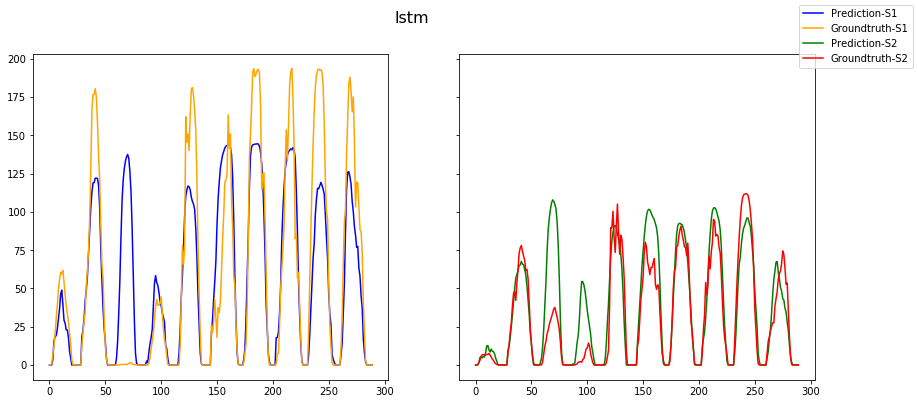

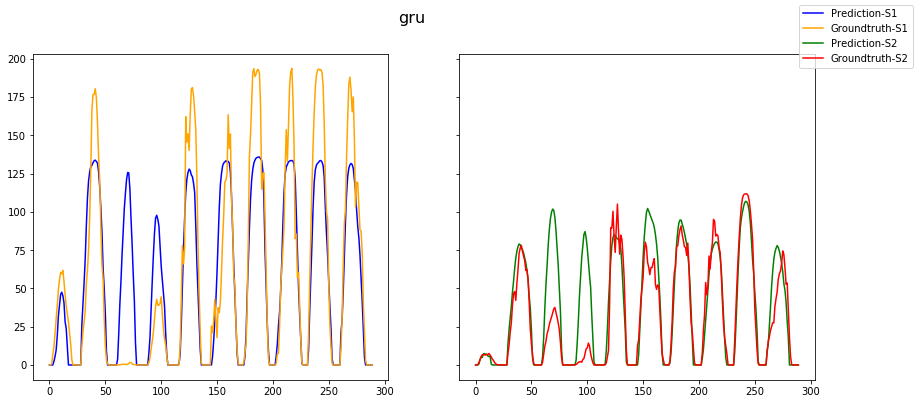

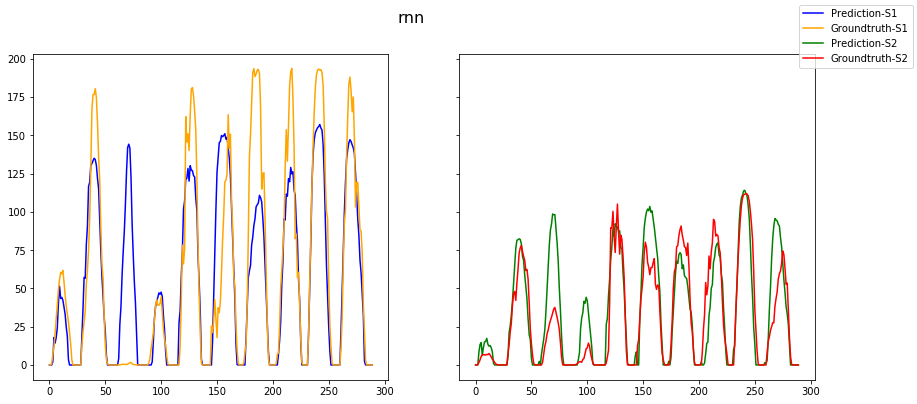

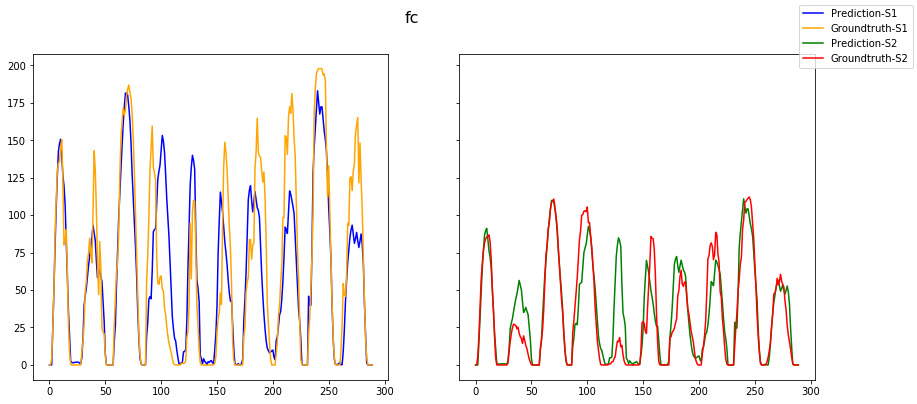

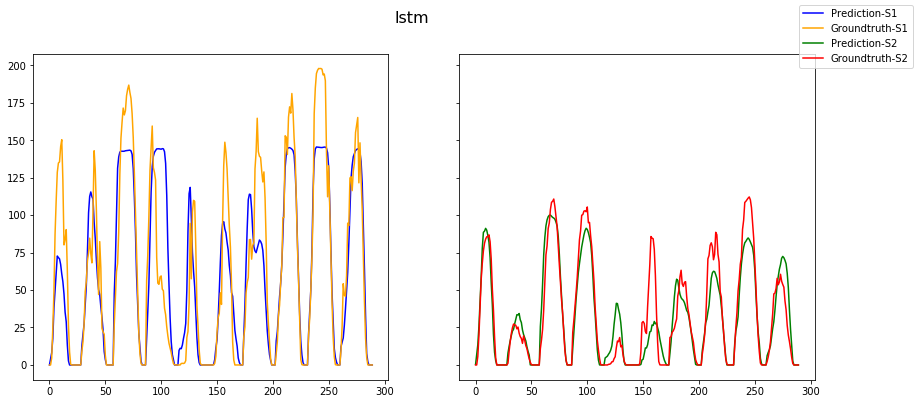

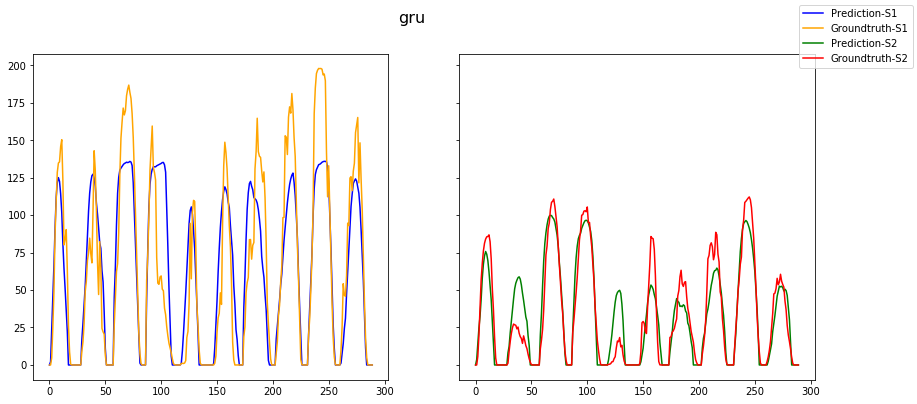

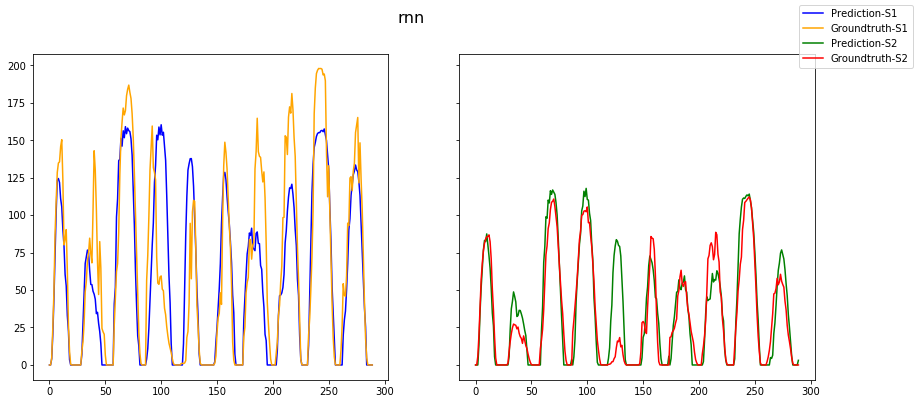

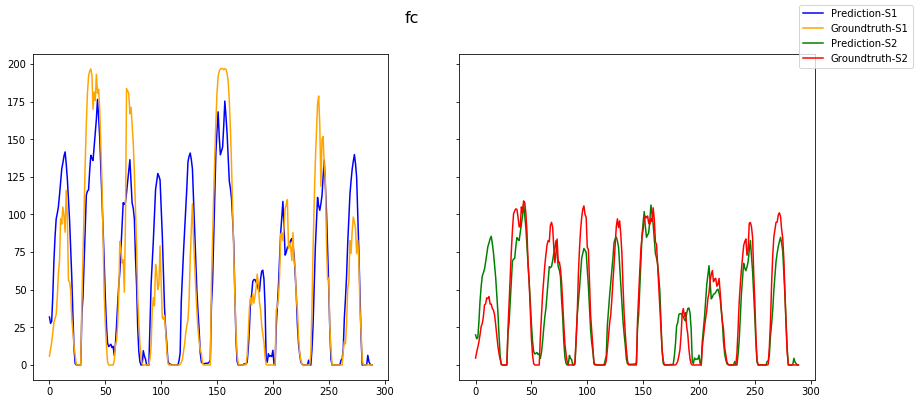

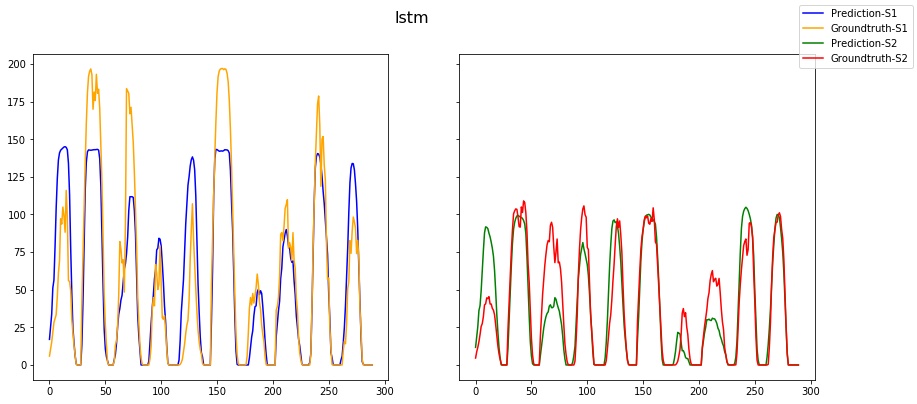

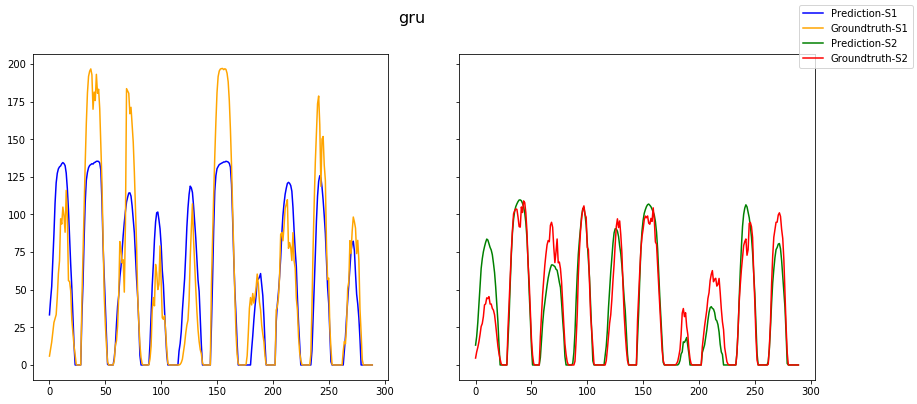

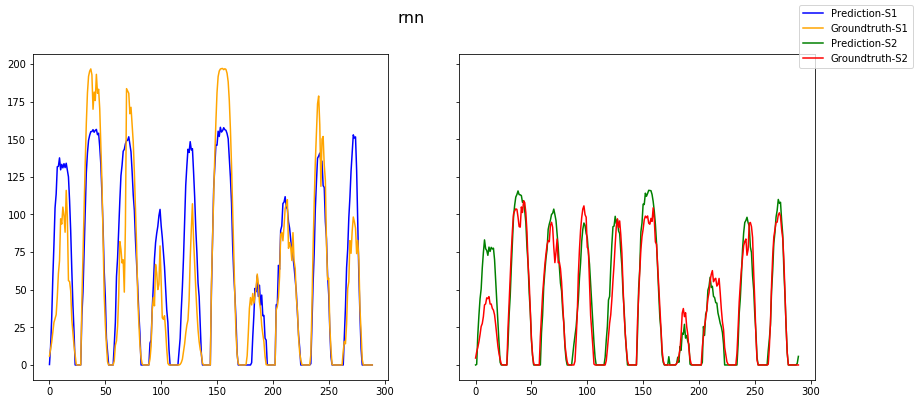

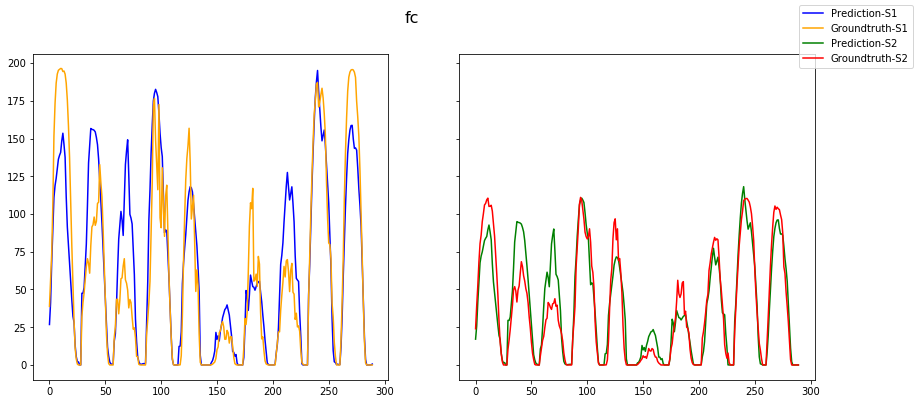

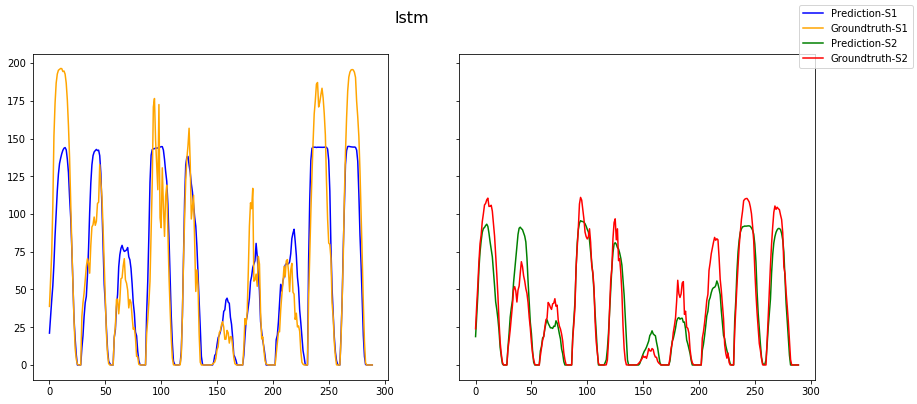

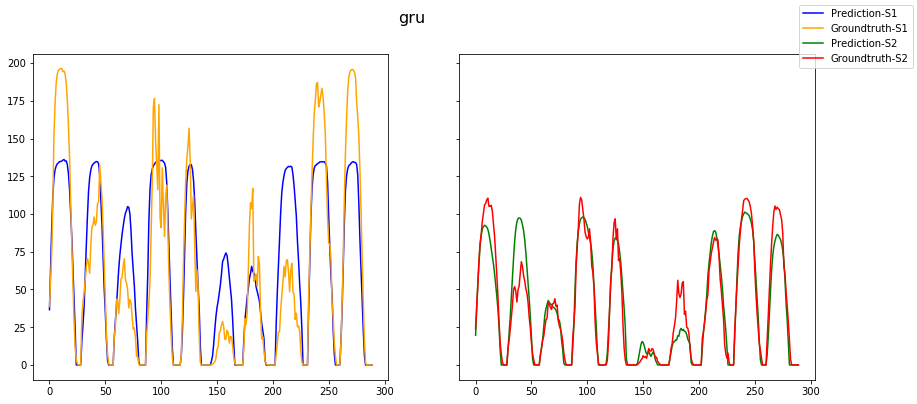

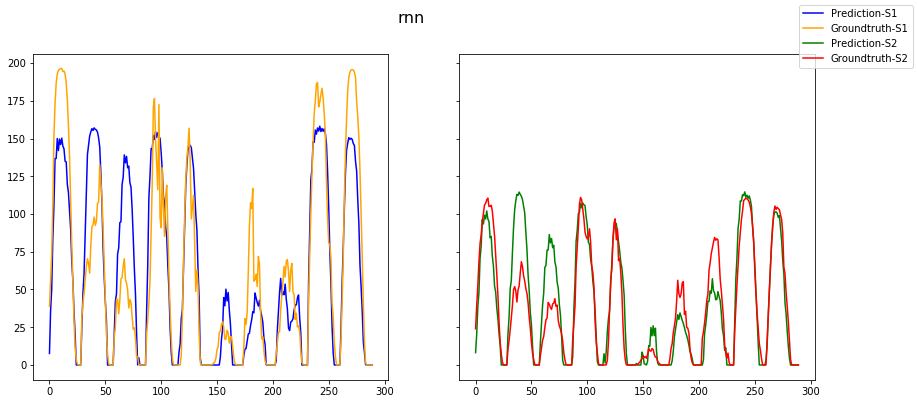

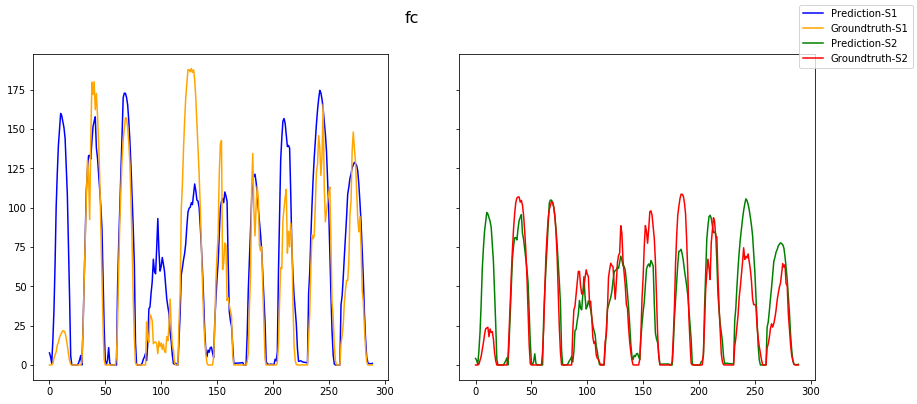

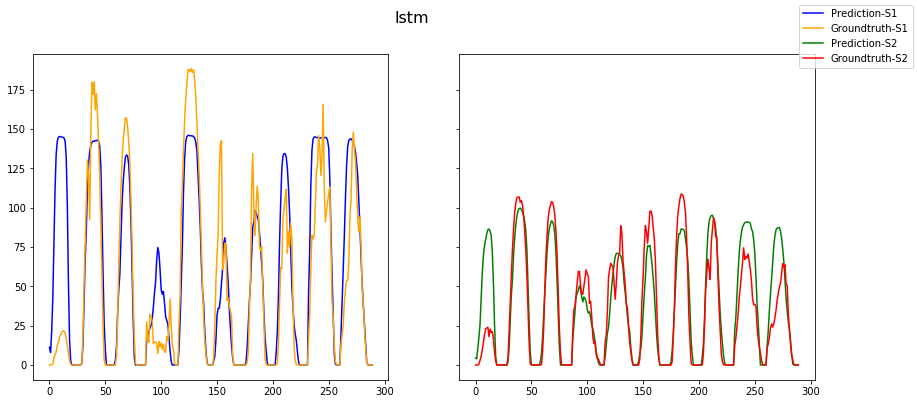

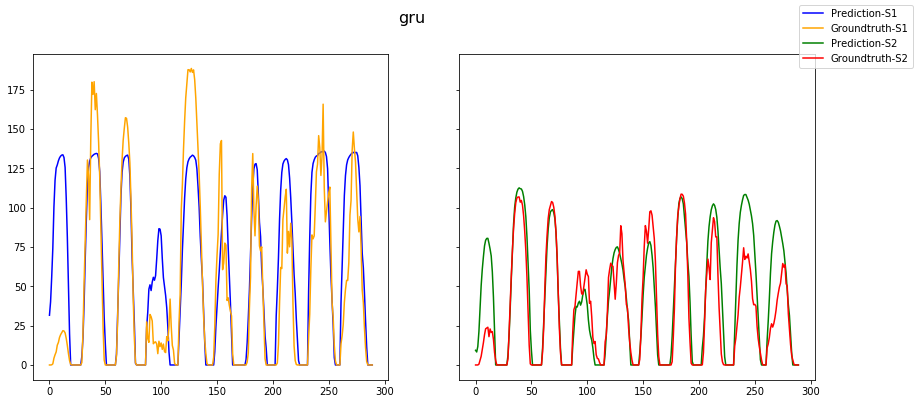

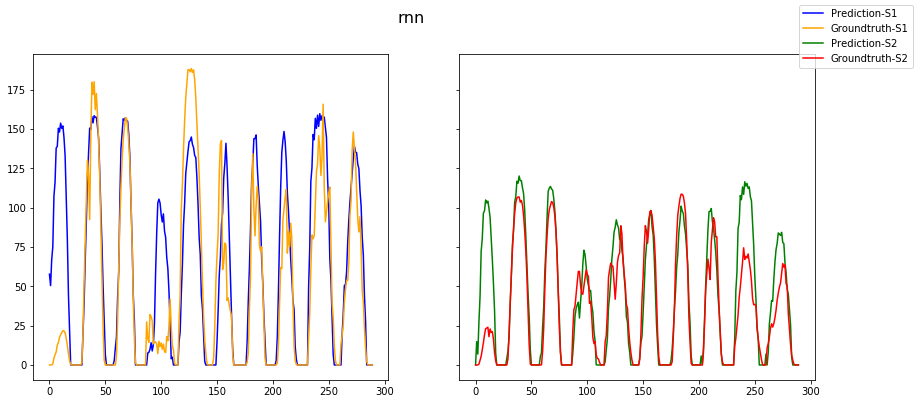

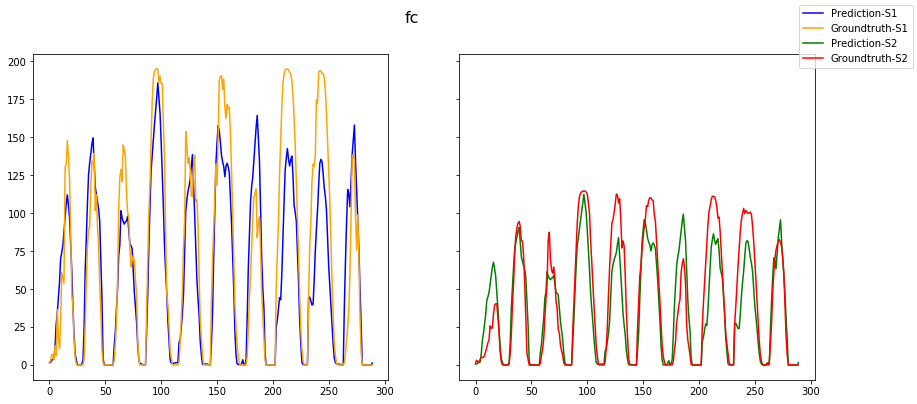

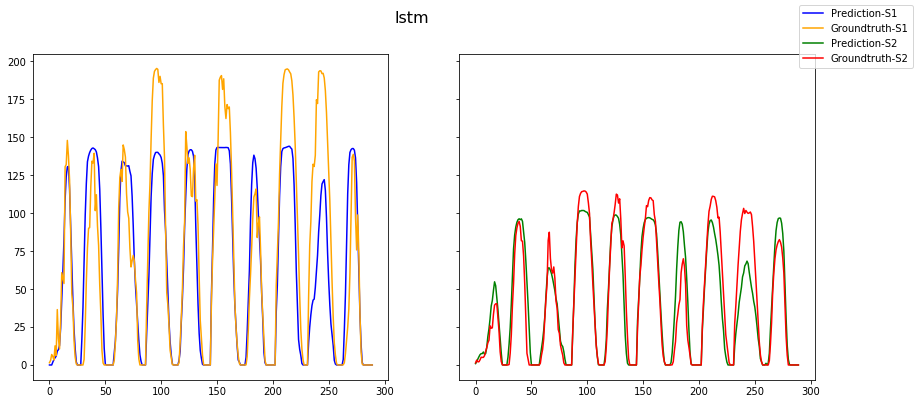

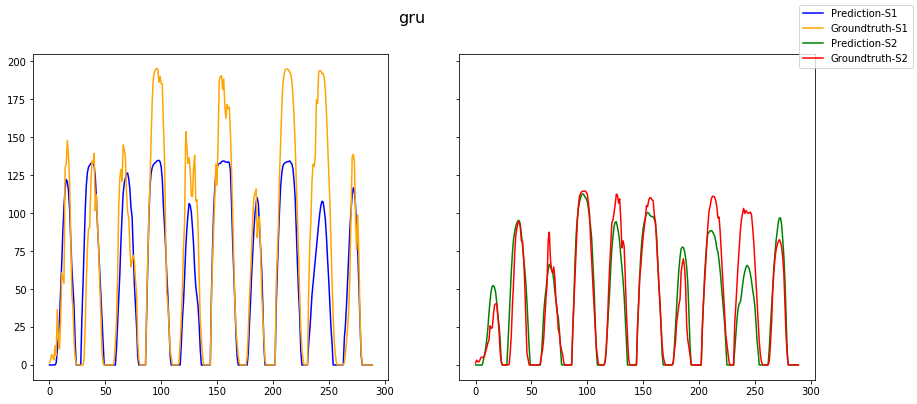

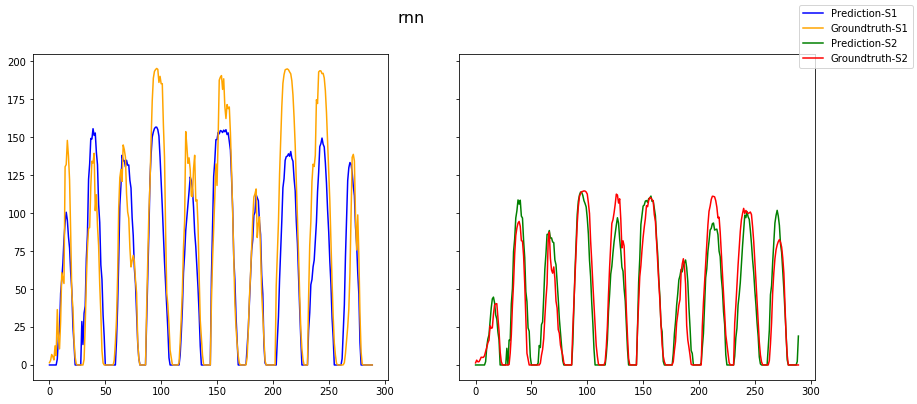

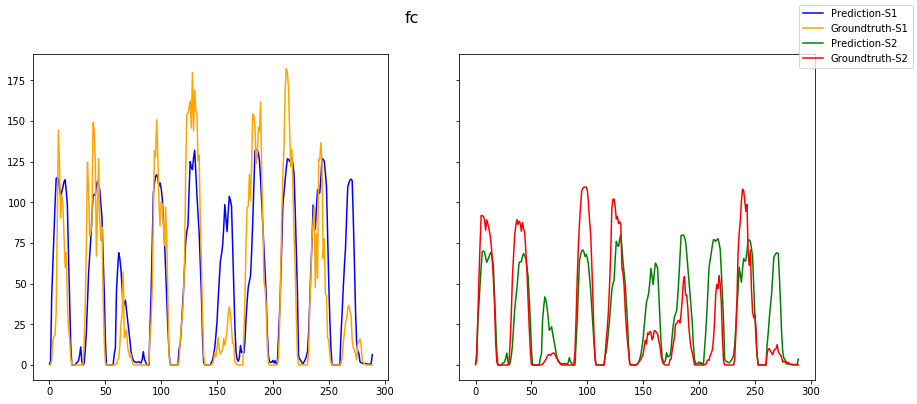

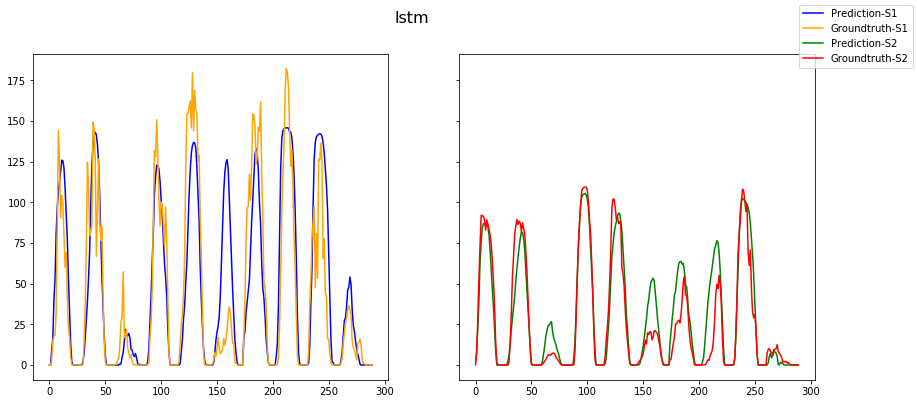

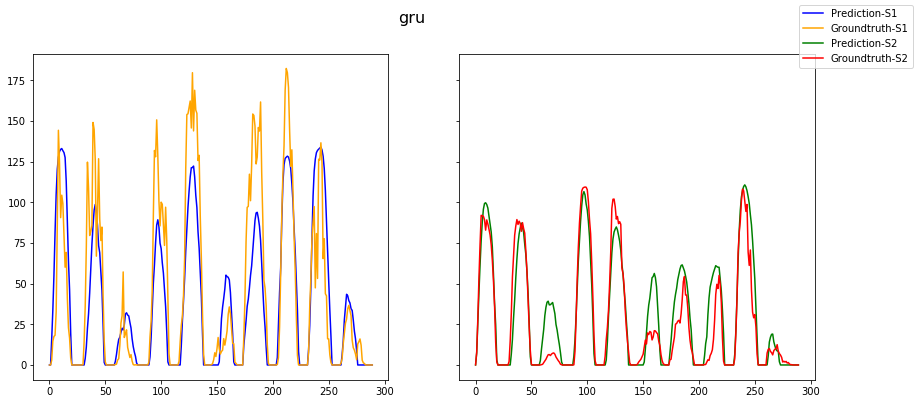

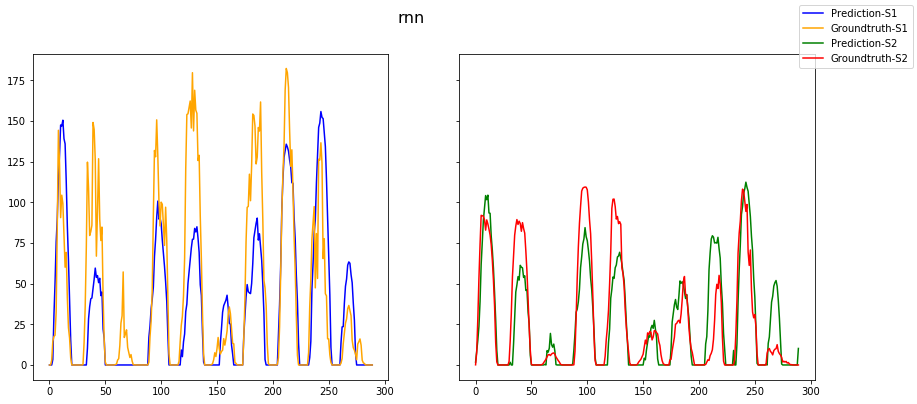

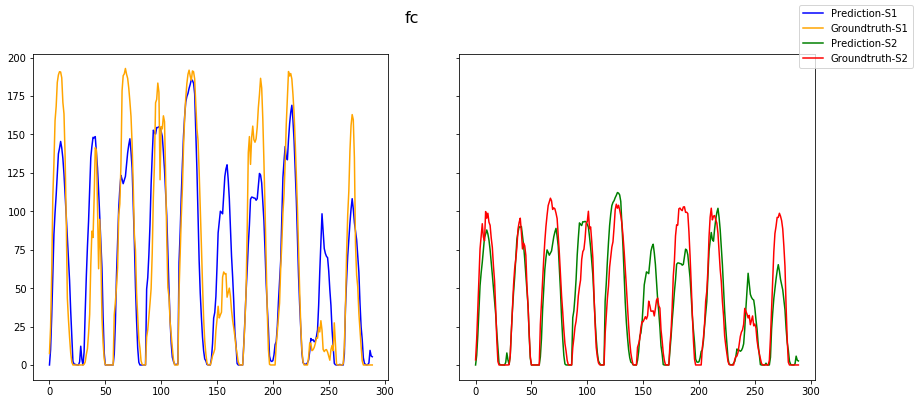

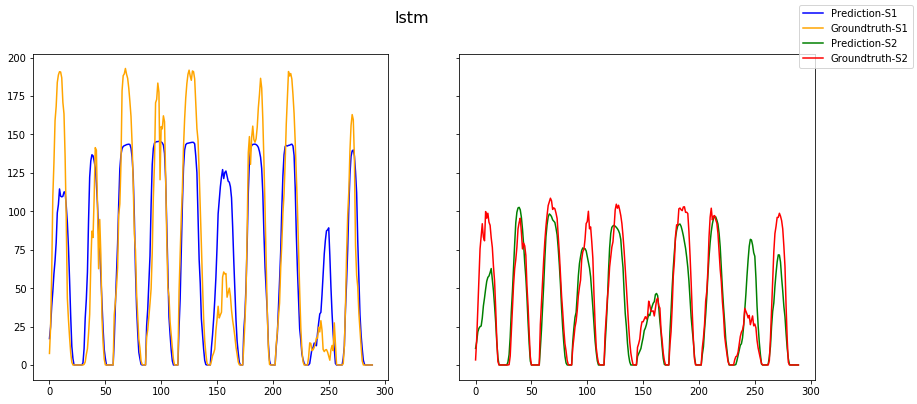

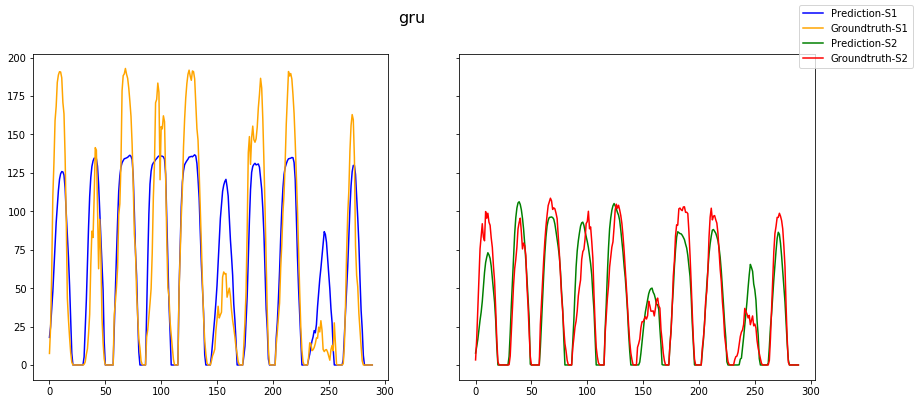

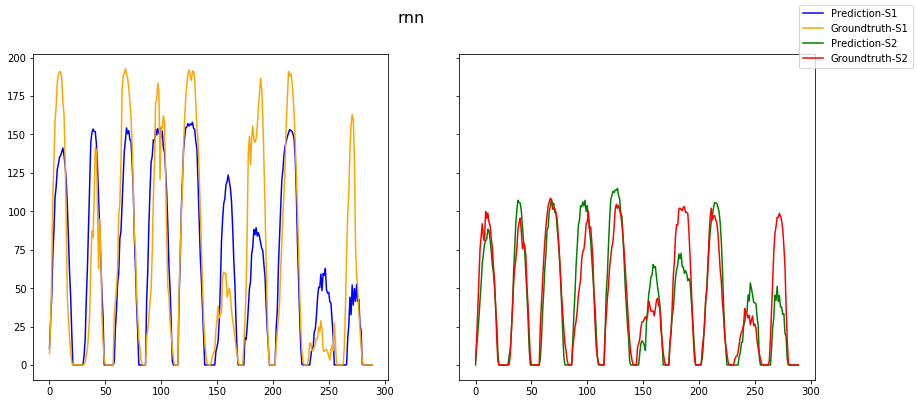

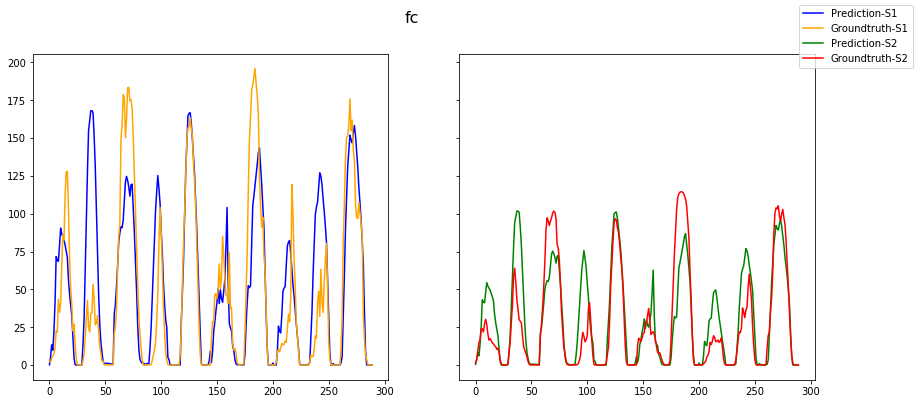

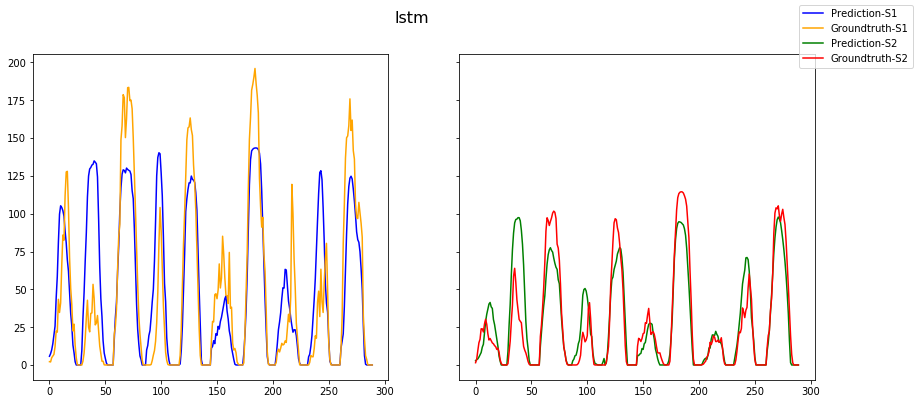

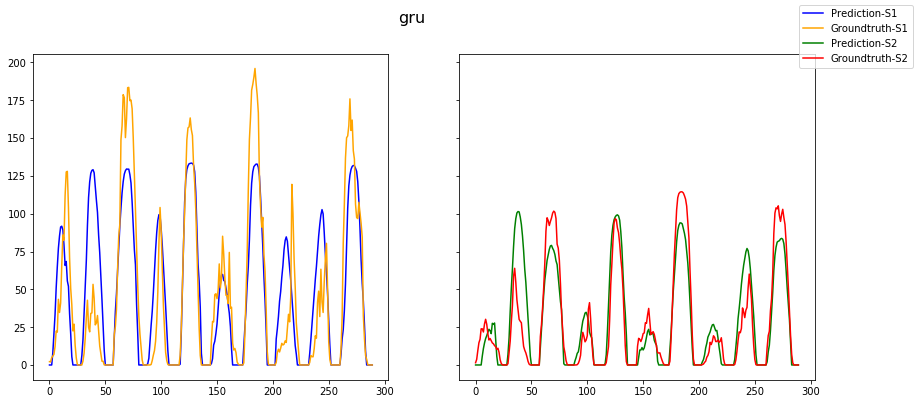

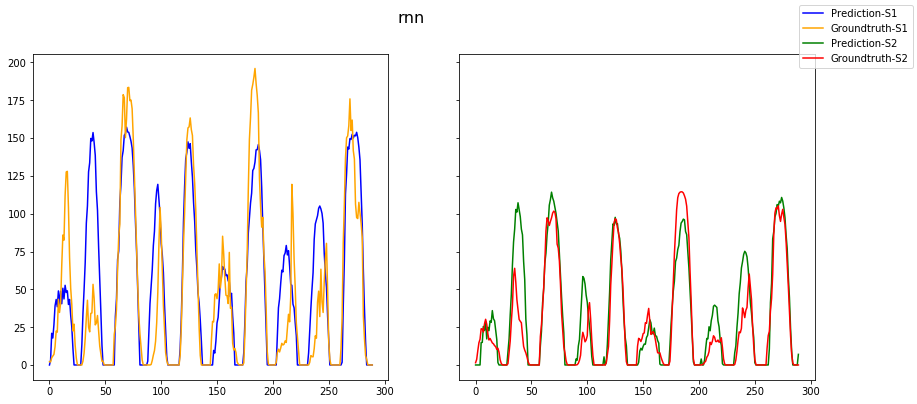

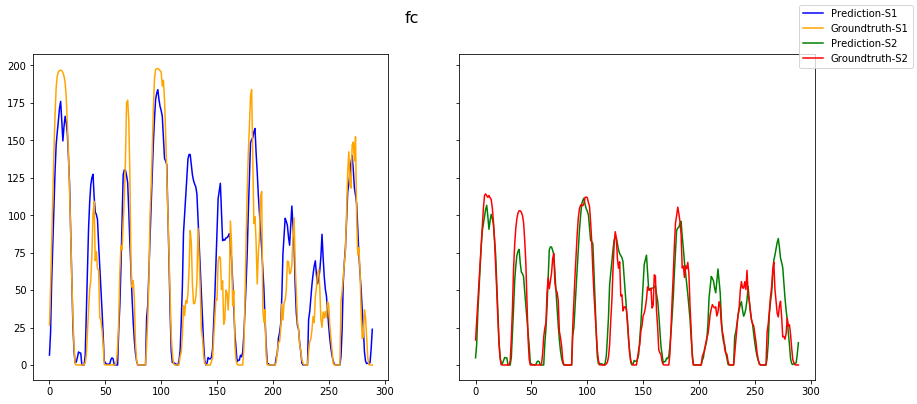

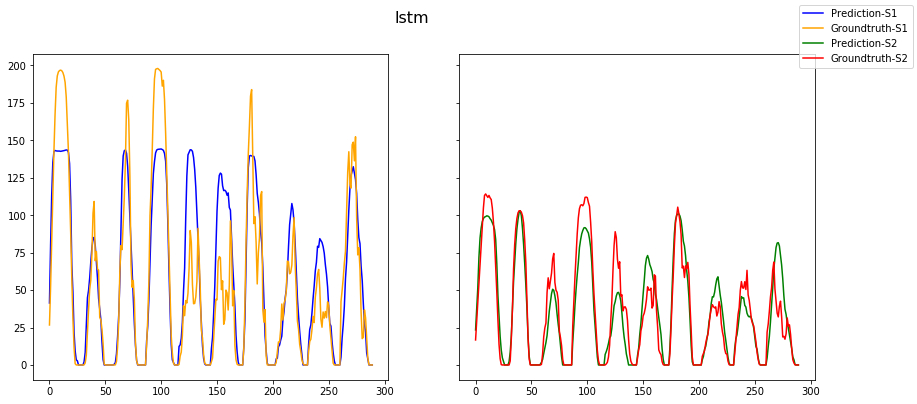

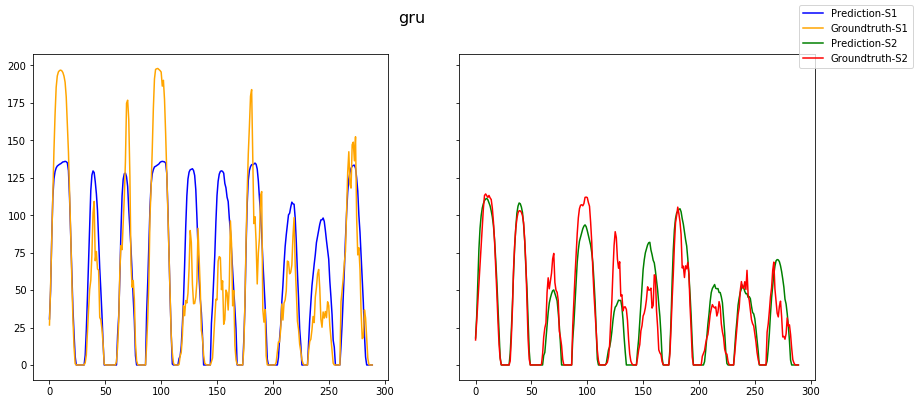

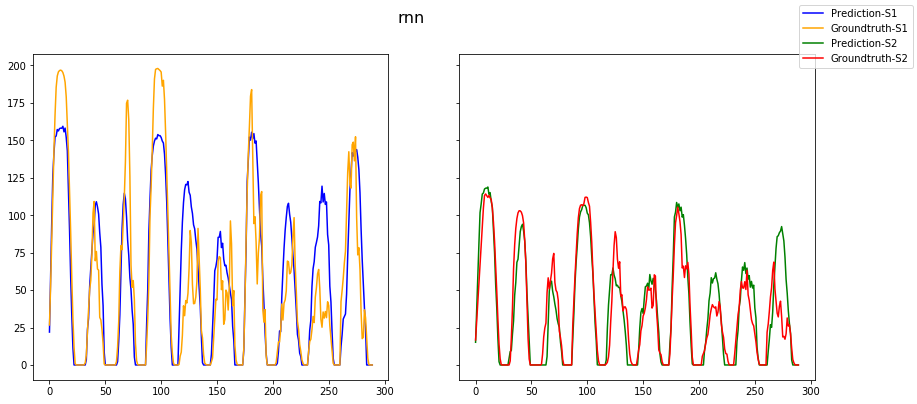

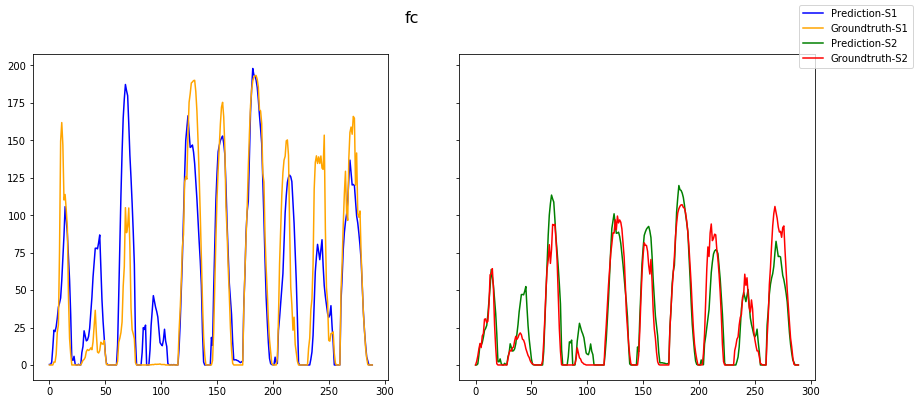

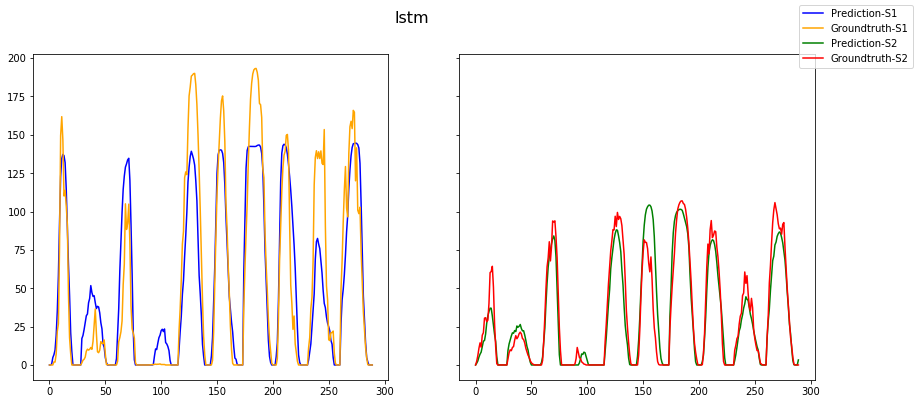

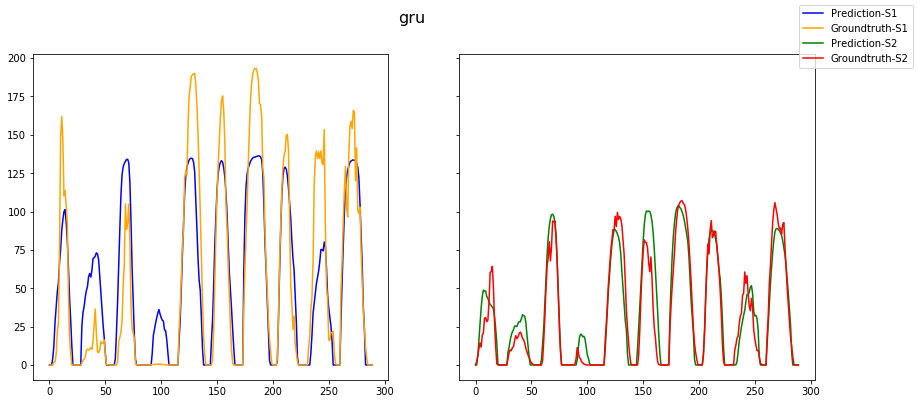

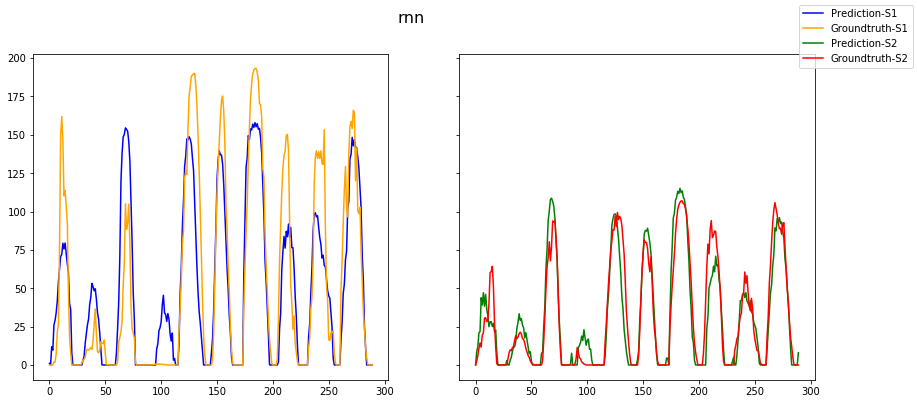

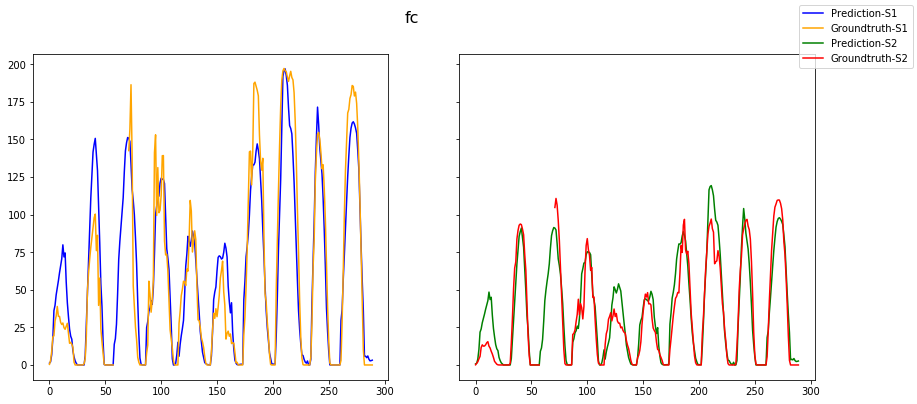

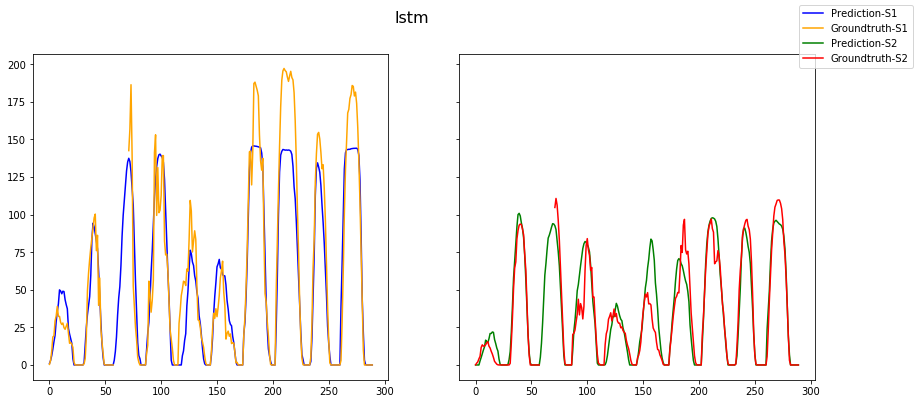

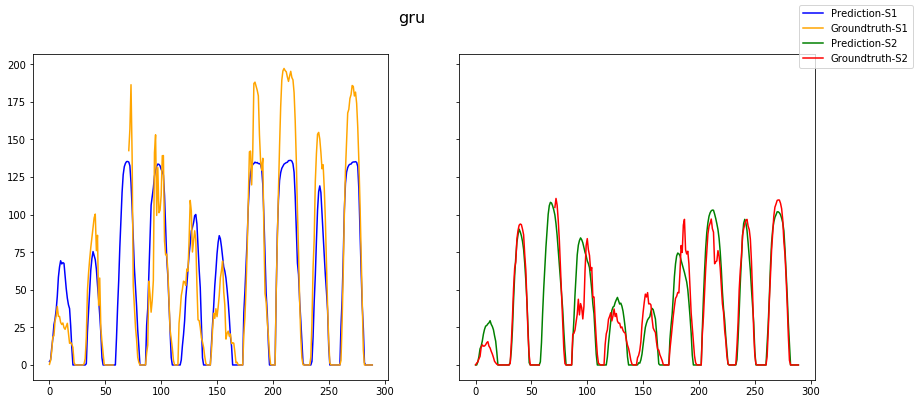

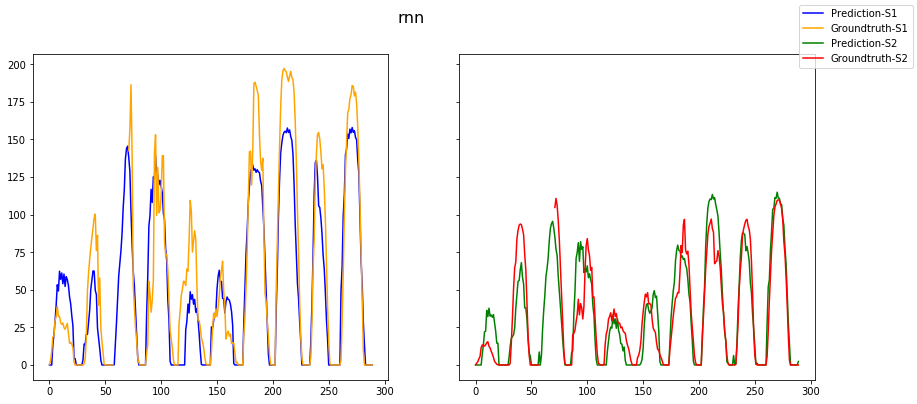

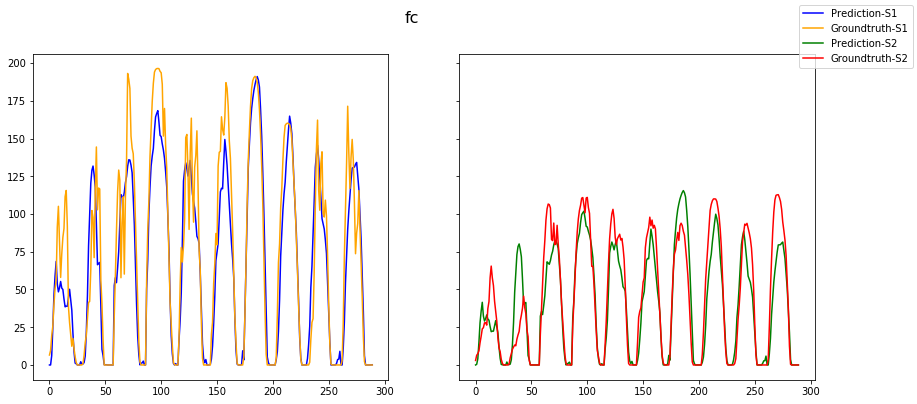

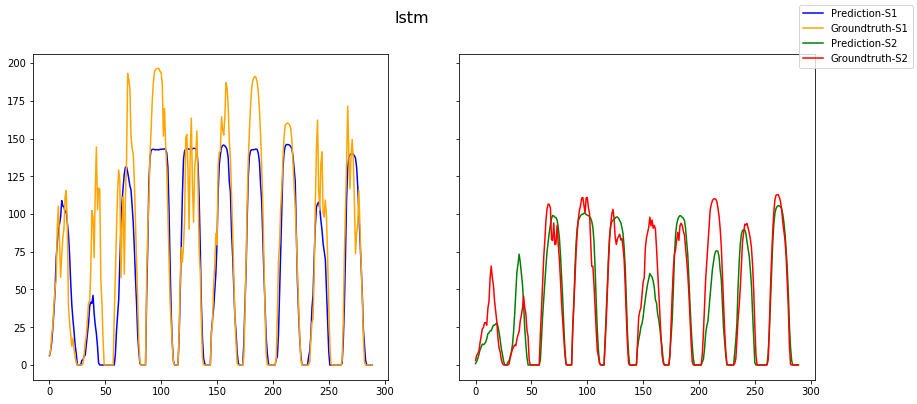

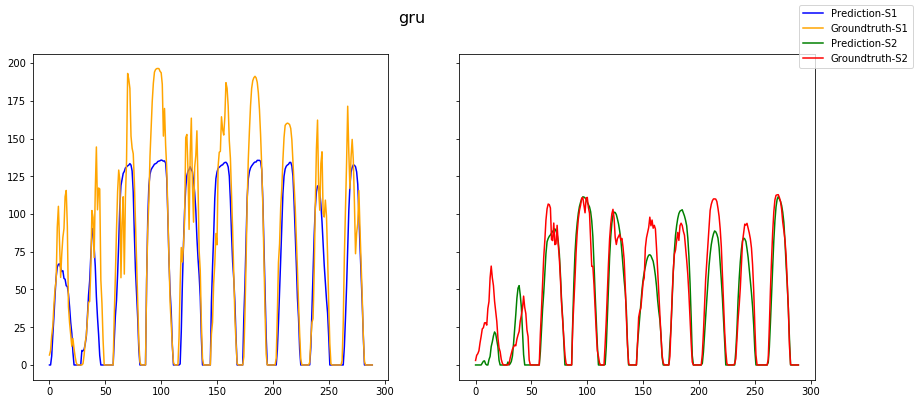

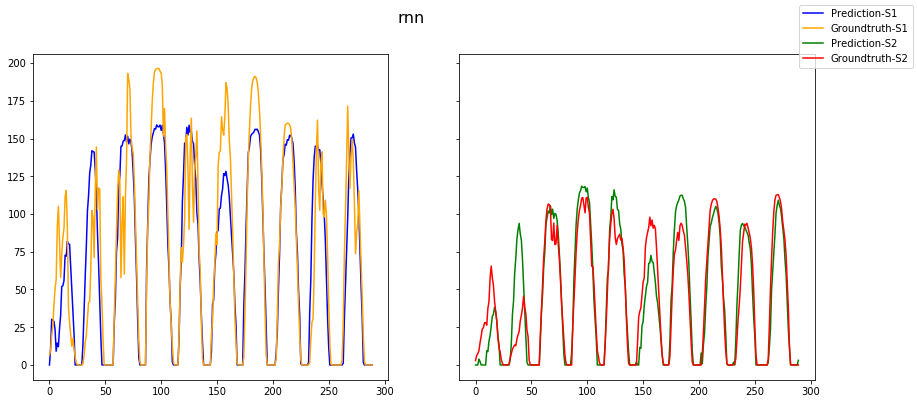

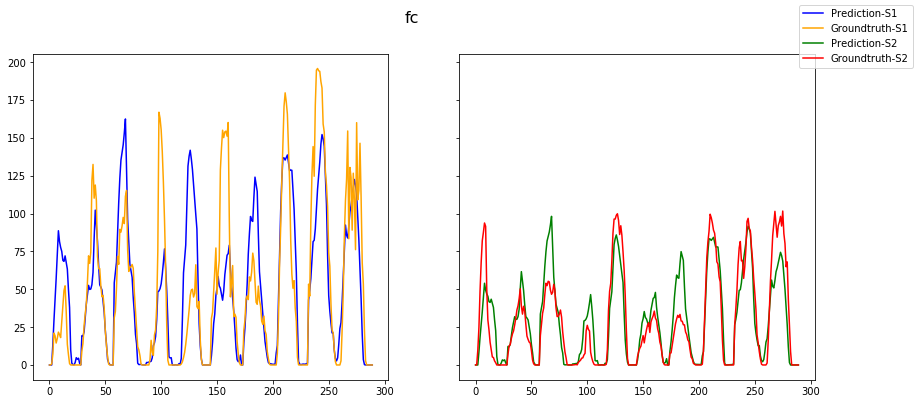

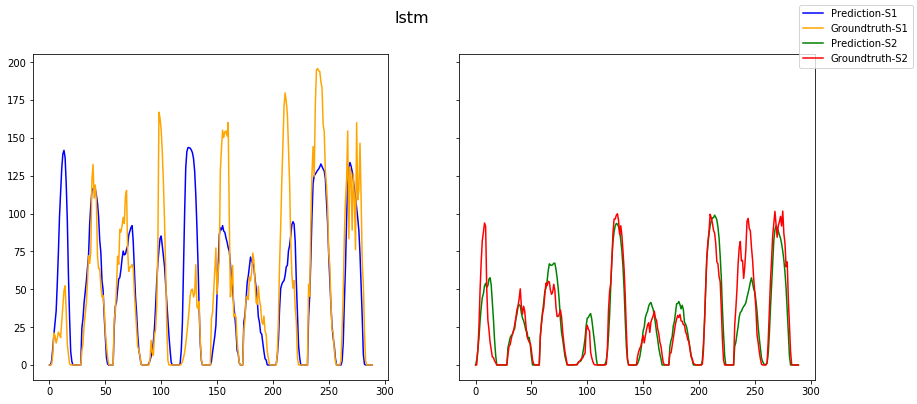

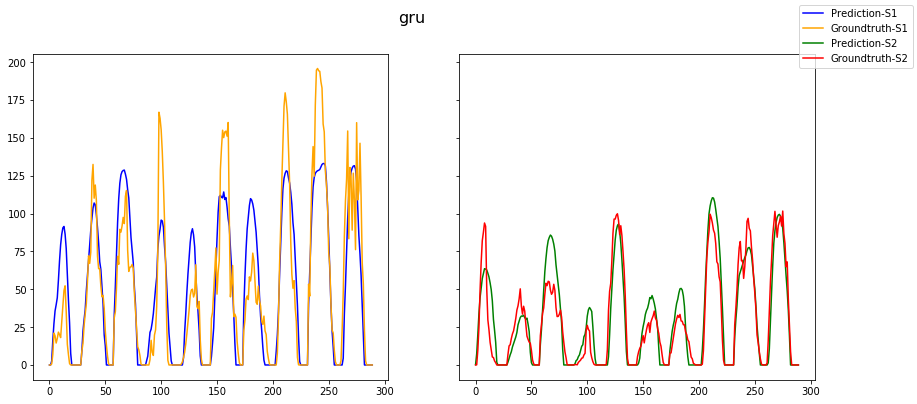

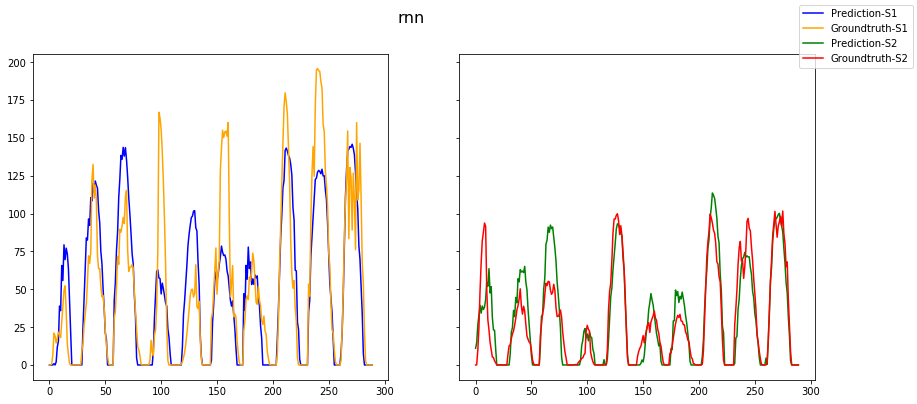

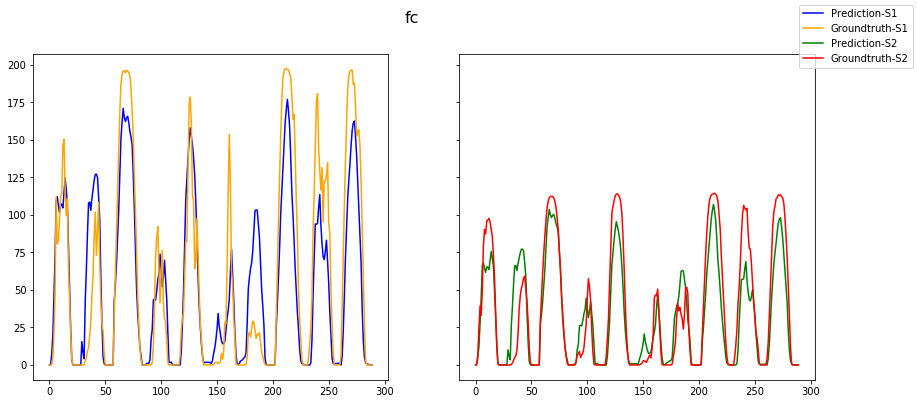

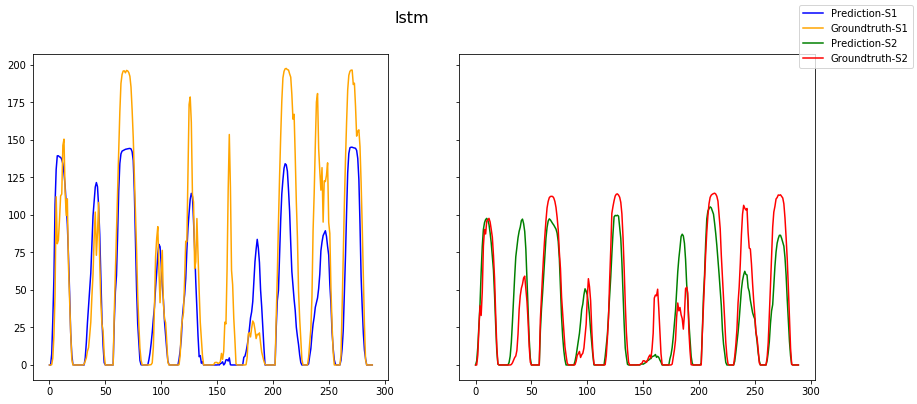

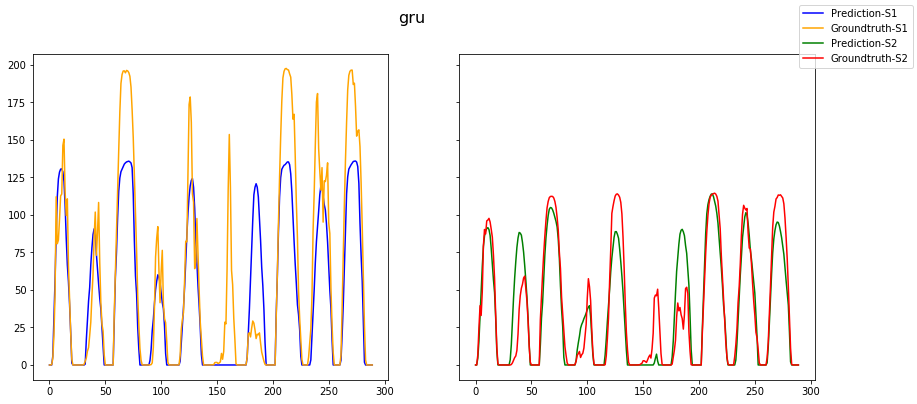

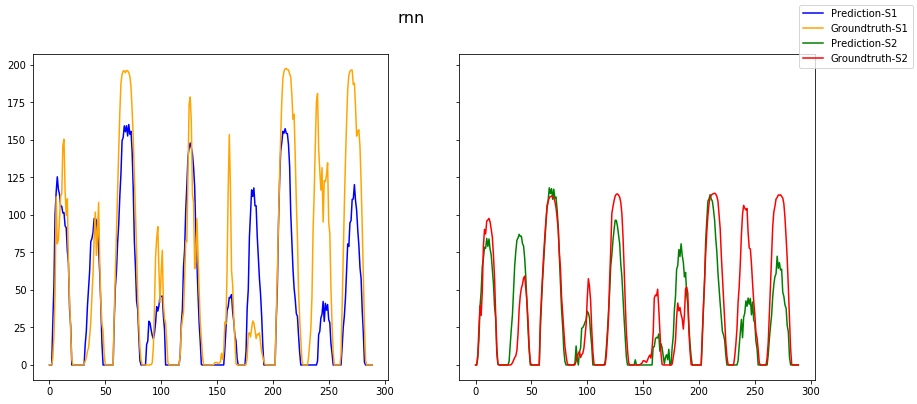

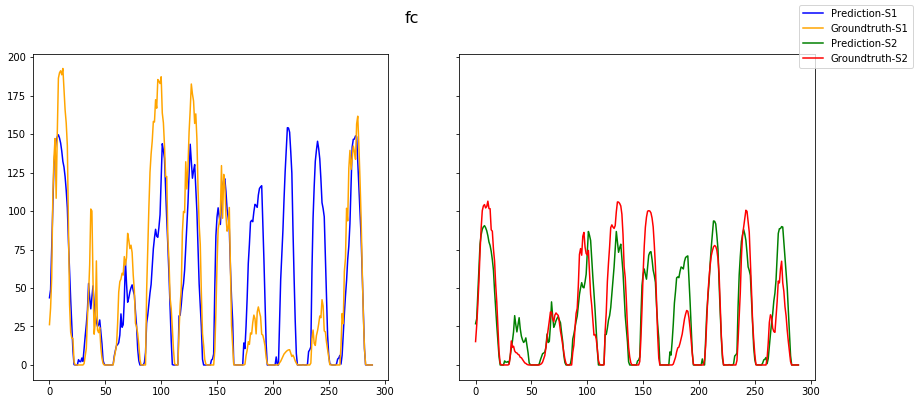

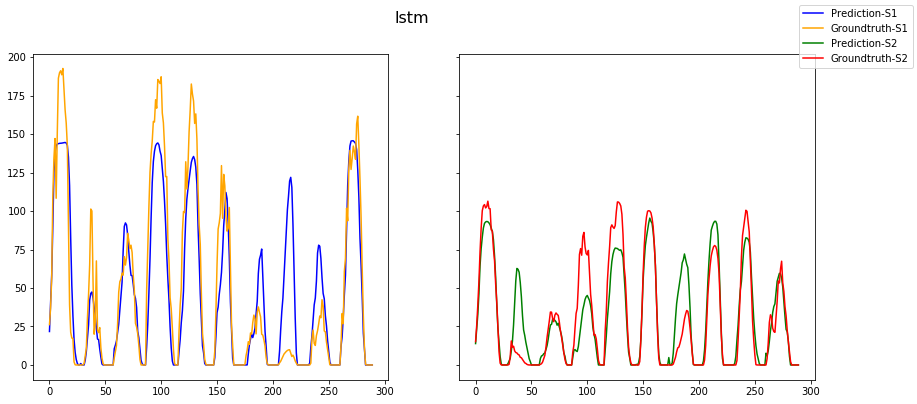

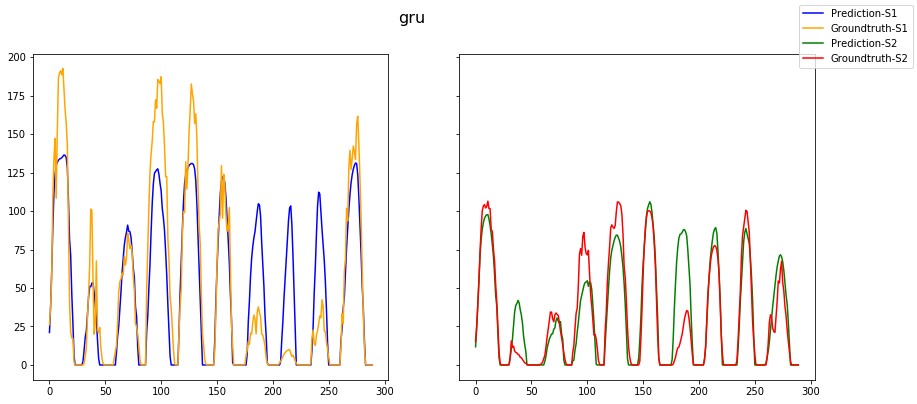

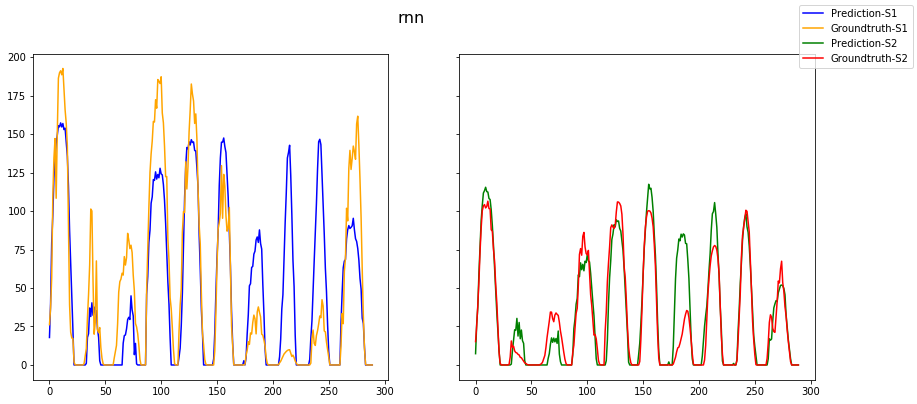

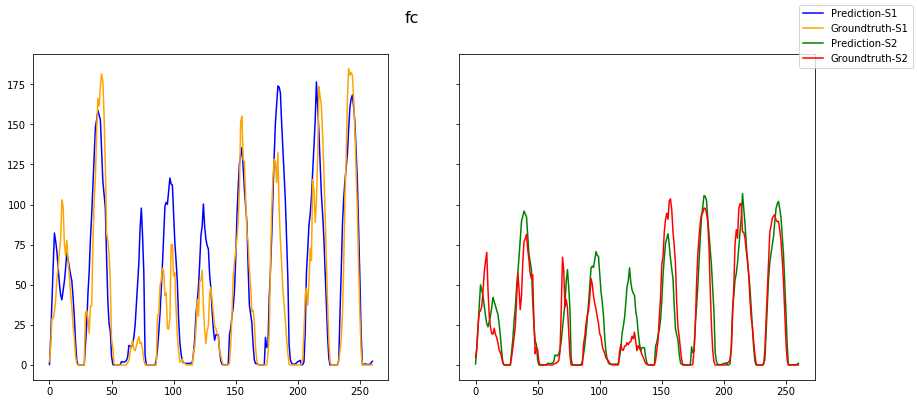

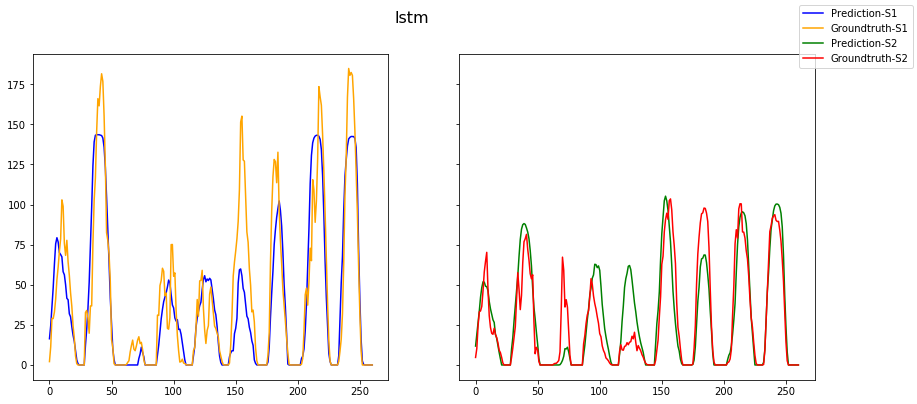

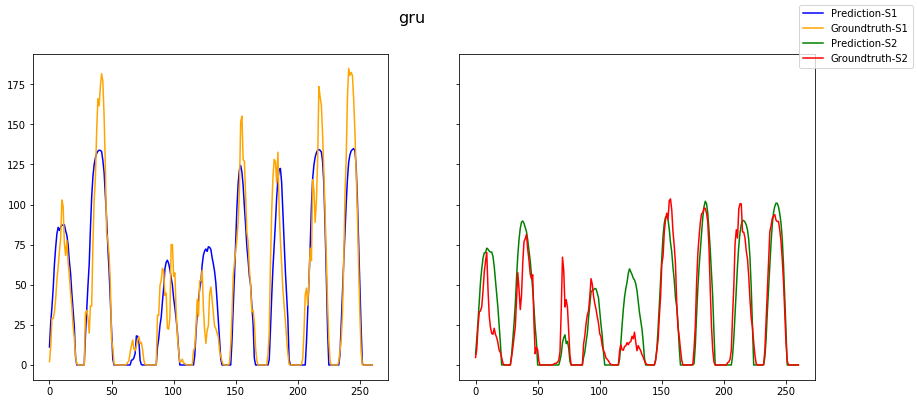

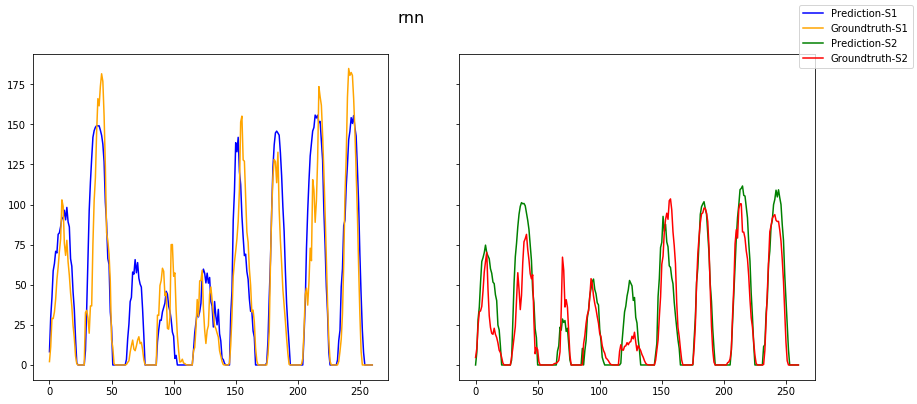

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_series(pred, true):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    shape = pred.shape
    pred = pred.reshape(((np.prod(shape[:2]),)+shape[2:]))
    true = true.reshape(((np.prod(shape[:2]),)+shape[2:]))
    index =  np.arange(np.prod(shape[:2]))
    
    ax1.plot(index, pred[:,0], label="Prediction-S1", color="blue")
    ax1.plot(index, true[:,0], label="Groundtruth-S1", color="orange")
    
    ax2.plot(index, pred[:,1], label="Prediction-S2", color="green")
    ax2.plot(index, true[:,1], label="Groundtruth-S2", color="red")
    
    f.legend()
    return f

test_loader = DataLoader(dataset=test_set,
                                batch_size=10, shuffle=False, pin_memory=True)

result_folder = "results_plots/"
with torch.no_grad():
    for iter_batch, test_batch in enumerate(test_loader):
        test_data, test_label = test_batch
        if use_gpu:
            test_data = test_data.cuda()
        for model in models:
            if use_gpu:
                model[0].cuda()
            f = plot_series(model[0](test_data).cpu().numpy(), test_label.numpy())
            f.suptitle(model[1], fontsize=16)
            f.set_size_inches(14, 6)
            path = join(result_folder, model[1]+"/")
            if not exists(path):
                makedirs(path)
            plt.savefig(join(path, "iter_%i"%iter_batch+".png"), bbox_inches='tight')

In [13]:
torch.save(model.state_dict(), join(output_dir, "last.torch"))

AttributeError: 'tuple' object has no attribute 'state_dict'